In [56]:
import os
import logging
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, f1_score, recall_score, 
    roc_curve, auc, ConfusionMatrixDisplay, mean_squared_error, r2_score
)

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from ydata_profiling import ProfileReport

import seaborn as sns

import shap
from catboost import CatBoostClassifier

plt.style.use('ggplot')
%matplotlib inline

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [57]:

class BikeDemandDataProcessor:
    def __init__(self, path):
        self.path = path

    def load_data(self, filename):
        full_path = f"{self.path}/{filename}"
        print(f"Loading data from {full_path}")
        try:
            return pd.read_csv(full_path)
        except FileNotFoundError:
            print(f"File {filename} not found in path {self.path}.")
            return None

    def preprocess(self, df):
        df = df.copy()
        df['timestamp'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str) + ':00:00', format='%d/%m/%Y %H:%M:%S')
        df.rename(columns={'hr': 'hour', 'yr' : 'year', 'mnth' : 'month', 'cnt' : 'count'}, inplace=True)
        df.drop(['dteday', 'instant'], axis=1, inplace=True)

        # Creating time-based features
        df['payday'] = df['timestamp'].dt.is_month_end.astype(int)
        df['year'] = df['timestamp'].dt.year
        df['day'] = df['timestamp'].dt.day_of_year
        df['day_of_week'] = df['timestamp'].dt.day_of_week
        df['day_of_month'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['week'] = df['timestamp'].dt.isocalendar().week
        df['year_sin'] = np.sin(2 * np.pi * df['year'])
        df['year_cos'] = np.cos(2 * np.pi * df['year'])
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) 
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['working_day'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)
        df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
        df['moonphase'] = df['timestamp'].apply(lambda x: (x.day + x.month * 29.53) % 29.53)
        df['quarter'] = df['timestamp'].dt.quarter
        df['christmas'] = df['timestamp'].apply(lambda x: 1 if x.month == 12 and x.day >= 20 else 0)
        df['day_of_year'] = df['timestamp'].dt.dayofyear

        # Creating rush hour feature
        df['rush_hour'] = df.apply(lambda x: 1 if ((x['hour'] >= 4 and x['hour'] <= 10) or (x['hour'] >= 15 and x['hour'] <= 21)) and x['working_day'] == 1 else 0, axis=1)

        # Convert object columns to category
        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype('category')

        return df.drop_duplicates()
    
    def feature_engineering(self, train_df, val_df):
        train_df = train_df.copy()
        val_df = val_df.copy()

        # Avoid division by zero
        casual_sum = train_df['casual'].sum()
        if casual_sum == 0:
            casual_sum = 1  # Prevent division by zero

        total_ratio_of_registered_uses = train_df['registered'].sum() / casual_sum

        # Average ratios for different time-based groupings
        average_hour_ratio = train_df.groupby('hour').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_day_ratio = train_df.groupby('day_of_week').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_week_ratio = train_df.groupby('week').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_month_ratio = train_df.groupby('month').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_season_ratio = train_df.groupby('season').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_weekend_ratio = train_df.groupby('weekend').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_working_day_ratio = train_df.groupby('working_day').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))

        # Applying ratios to both train and validation sets
        train_df['total_registered_ratio'] = total_ratio_of_registered_uses
        val_df['total_registered_ratio'] = total_ratio_of_registered_uses

        train_df['hour_ratio'] = train_df['hour'].map(average_hour_ratio)
        val_df['hour_ratio'] = val_df['hour'].map(average_hour_ratio)

        train_df['day_ratio'] = train_df['day_of_week'].map(average_day_ratio)
        val_df['day_ratio'] = val_df['day_of_week'].map(average_day_ratio)

        # Now use these ratios wherever needed for working day and weekend conditions
        train_df['working_day_or_weekend_ratio'] = train_df['working_day'].map(average_working_day_ratio).where(train_df['working_day'] == 1, 
                                                                                                                        train_df['weekend'].map(average_weekend_ratio))
        val_df['working_day_or_weekend_ratio'] = val_df['working_day'].map(average_working_day_ratio).where(val_df['working_day'] == 1, 
                                                                                                                    val_df['weekend'].map(average_weekend_ratio))

        train_df['week_ratio'] = train_df['week'].map(average_week_ratio)
        val_df['week_ratio'] = val_df['week'].map(average_week_ratio)

        train_df['month_ratio'] = train_df['month'].map(average_month_ratio)
        val_df['month_ratio'] = val_df['month'].map(average_month_ratio)

        train_df['season_ratio'] = train_df['season'].map(average_season_ratio)
        val_df['season_ratio'] = val_df['season'].map(average_season_ratio)

        # Dropping original target columns
        train_df.drop(['casual', 'registered'], axis=1, inplace=True)
        val_df.drop(['casual', 'registered'], axis=1, inplace=True)

        # Aggregate counts to daily level
        daily_train_df = train_df.groupby(['year', 'month', 'day', 'day_of_year'])[['count']].sum().reset_index()


        # Calculate rolling mean and standard deviation (2-week window)
        rolling_mean = daily_train_df['count'].rolling(window=14, center=True).mean()
        rolling_std = daily_train_df['count'].rolling(window=14, center=True).std()

        # Identify 3-sigma outliers
        daily_train_df['sigma_3_outlier'] = (daily_train_df['count'] > rolling_mean + 3 * rolling_std) | \
                                            (daily_train_df['count'] < rolling_mean - 3 * rolling_std)

        # Find max outlier flag per day_of_year
        day_of_year_outlier = daily_train_df.groupby('day_of_year', as_index=False)['sigma_3_outlier'].max()

        # Merge back into train_df and val_df
        train_df = train_df.merge(day_of_year_outlier, on='day_of_year', how='left')
        val_df = val_df.merge(day_of_year_outlier, on='day_of_year', how='left')

        # Fill NaN values (if no outlier was detected for that day, assume False)
        train_df['sigma_3_outlier'].fillna(False, inplace=True)
        val_df['sigma_3_outlier'].fillna(False, inplace=True)


        return train_df.drop_duplicates(), val_df.drop_duplicates()

        

        return train_df.drop_duplicates(), val_df.drop_duplicates()
    
    def split_and_engineer_data(self, df):
        sorted_df = df.sort_values('timestamp').copy()
        sorted_df.drop('timestamp', axis=1, inplace=True)

        train_df, val_df = train_test_split(sorted_df, test_size=0.2, shuffle=False)

        train_df, val_df = self.feature_engineering(train_df, val_df)

        return train_df, val_df


# Data Loading

In [58]:
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)

In [59]:
parent_path

PosixPath('/Users/lawrence/Documents/PYTHON/saga_tech_test_2025')

In [60]:
hour_raw_df = processor.load_data("hour.csv")

Loading data from /Users/lawrence/Documents/PYTHON/saga_tech_test_2025/hour.csv


In [61]:
hour_raw_df.head(5)

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  01/01/2011       1   0     1   0        0        6           0   
1        2  01/01/2011       1   0     1   1        0        6           0   
2        3  01/01/2011       1   0     1   2        0        6           0   
3        4  01/01/2011       1   0     1   3        0        6           0   
4        5  01/01/2011       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [62]:
hour_processed_df = processor.preprocess(hour_raw_df)

In [63]:
hour_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   season        17379 non-null  int64         
 1   year          17379 non-null  int32         
 2   month         17379 non-null  int32         
 3   hour          17379 non-null  int64         
 4   holiday       17379 non-null  int64         
 5   weekday       17379 non-null  int64         
 6   workingday    17379 non-null  int64         
 7   weathersit    17379 non-null  int64         
 8   temp          17379 non-null  float64       
 9   atemp         17379 non-null  float64       
 10  hum           17379 non-null  float64       
 11  windspeed     17379 non-null  float64       
 12  casual        17379 non-null  int64         
 13  registered    17379 non-null  int64         
 14  count         17379 non-null  int64         
 15  timestamp     17379 non-null  dateti

In [64]:
hour_processed_df.head()

season  year  month  hour  holiday  weekday  workingday  weathersit  temp  \
0       1  2011      1     0        0        6           0           1  0.24   
1       1  2011      1     1        0        6           0           1  0.22   
2       1  2011      1     2        0        6           0           1  0.22   
3       1  2011      1     3        0        6           0           1  0.24   
4       1  2011      1     4        0        6           0           1  0.24   

    atemp  ...  day_cos  hour_sin  hour_cos  working_day  weekend moonphase  \
0  0.2879  ...  0.97953  0.000000  1.000000            0        1       1.0   
1  0.2727  ...  0.97953  0.258819  0.965926            0        1       1.0   
2  0.2727  ...  0.97953  0.500000  0.866025            0        1       1.0   
3  0.2879  ...  0.97953  0.707107  0.707107            0        1       1.0   
4  0.2879  ...  0.97953  0.866025  0.500000            0        1       1.0   

   quarter  christmas  day_of_year  rush_hour  
0        1          0            1          0  
1        1          0            1          0  
2        1          0            1          0  
3        1          0            1          0  
4        1          0            1          0  

[5 rows x 36 columns]

In [65]:
null_counts = hour_processed_df.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


In [66]:
# Display the first few rows of the relevant columns to check alignment
hour_processed_df[['day', 'day_of_week', 'workingday', 'weekend']].drop_duplicates().head(10)

day  day_of_week  workingday  weekend
0      1            5           0        1
24     2            6           0        1
47     3            0           1        0
69     4            1           1        0
92     5            2           1        0
115    6            3           1        0
138    7            4           1        0
161    8            5           0        1
185    9            6           0        1
209   10            0           1        0

In [67]:
missing_hours = hour_processed_df.set_index('timestamp').groupby([hour_processed_df['timestamp'].dt.date]).apply(lambda x: x['hour'].nunique() != 24)

missing_days = missing_hours[missing_hours].index
print(f"Days with missing hours: {missing_days}")

Days with missing hours: Index([], dtype='object', name='timestamp')


## Dataset Characteristics

Both `hour.csv` and `day.csv` have the following fields, except `hr` which is not available in `day.csv`:

- **instant**: record index
- **dteday**: date
- **season**: season (1: spring, 2: summer, 3: fall, 4: winter)
- **yr**: year (0: 2011, 1: 2012)
- **mnth**: month (1 to 12)
- **hr**: hour (0 to 23)
- **holiday**: whether the day is a holiday or not
- **day_of_week**: day of the week
- **workingday**: if the day is neither weekend nor holiday is 1, otherwise is 0
- **weathersit**:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp**: Normalized temperature in Celsius. The values are divided by 41 (max)
- **atemp**: Normalized feeling temperature in Celsius. The values are divided by 50 (max)
- **hum**: Normalized humidity. The values are divided by 100 (max)
- **windspeed**: Normalized wind speed. The values are divided by 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered
```

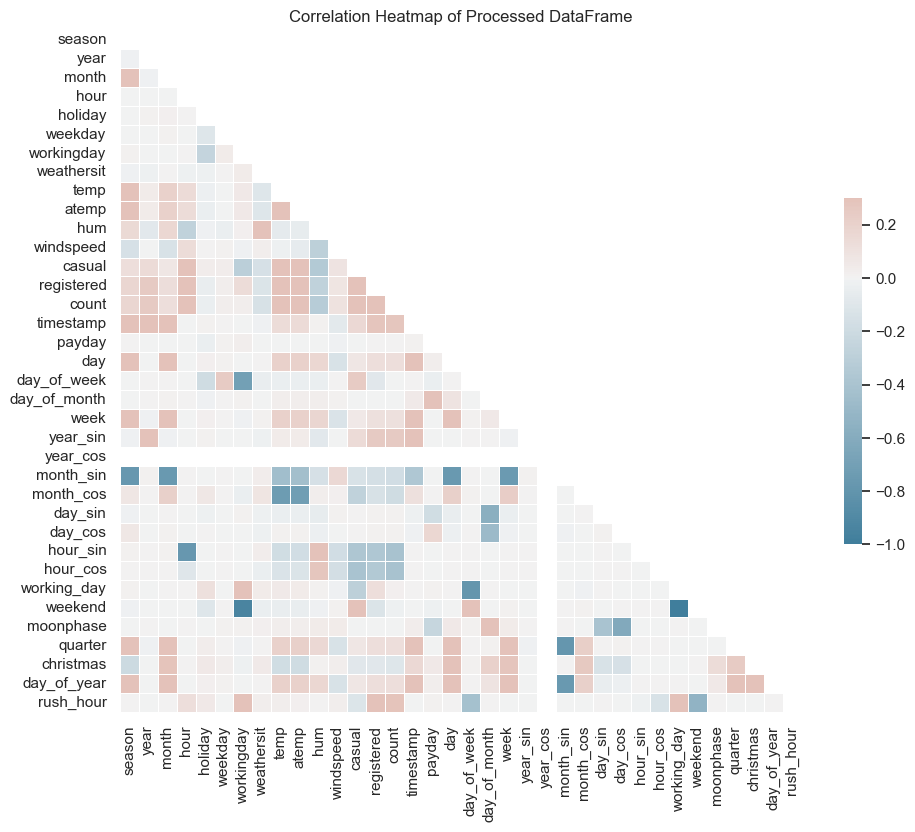

In [68]:
hour_processed_df_numeric = hour_processed_df.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

sns.set_theme(style="white")

corr = hour_processed_df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Processed DataFrame')
plt.show()

In [69]:
# hour_processed_df_profile = ProfileReport(hour_processed_df, title="Pandas Profiling Report for hour_processed_df")
# hour_processed_df_profile.to_notebook_iframe()

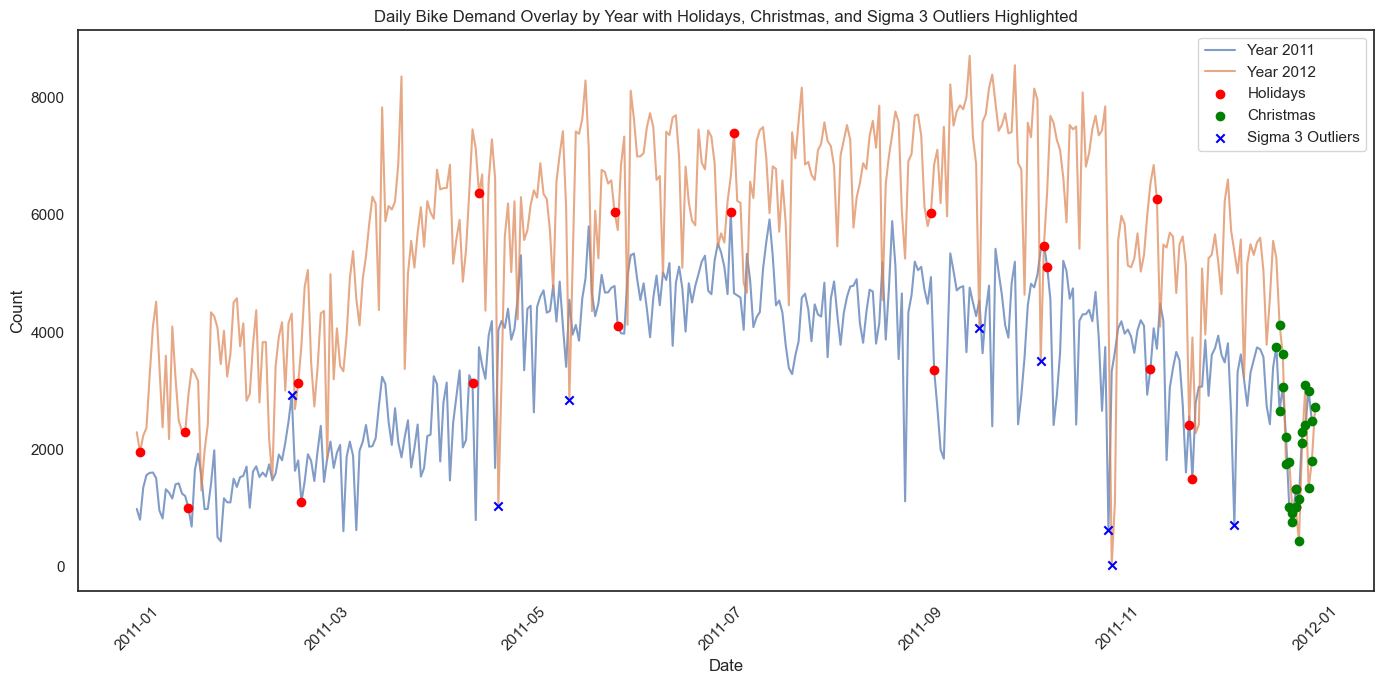

In [70]:
# Ensure datetime index
daily_counts = hour_processed_df.resample('D', on='timestamp').agg({
    'holiday': 'max',
    'christmas': 'max',
    'count': 'sum',
})
daily_counts.index = pd.to_datetime(daily_counts.index)

# Extract year for grouping
daily_counts['year'] = daily_counts.index.year

# Convert to day-of-year, then reconstruct in a common year (2011)
daily_counts['day_of_year'] = daily_counts.index.dayofyear
daily_counts['normalized_date'] = pd.to_datetime('2011-01-01') + pd.to_timedelta(daily_counts['day_of_year'] - 1, unit='D')

# Sort the data
daily_counts = daily_counts.sort_values(['year', 'normalized_date'])

# Calculate rolling mean and standard deviation with a 2-week window
rolling_mean = daily_counts['count'].rolling(window=30, center=True).mean()
rolling_std = daily_counts['count'].rolling(window=30, center=True).std()

# Identify sigma 3 outliers
daily_counts['sigma_3_outlier'] = (daily_counts['count'] > rolling_mean + 3 * rolling_std) | (daily_counts['count'] < rolling_mean - 3 * rolling_std)

# Plot
plt.figure(figsize=(14, 7))

for year in daily_counts['year'].unique():
    yearly_data = daily_counts[daily_counts['year'] == year]
    plt.plot(yearly_data['normalized_date'], yearly_data['count'], label=f'Year {year}', alpha=0.7)

# Highlight holidays
holidays = daily_counts[daily_counts['holiday'] == 1]
plt.scatter(holidays['normalized_date'], holidays['count'], color='red', label='Holidays', zorder=5)

# Highlight Christmas with a green marker
christmas = daily_counts[daily_counts['christmas'] == 1]
plt.scatter(christmas['normalized_date'], christmas['count'], color='green', label='Christmas', marker='o', zorder=6)

# Highlight sigma 3 outliers with a blue marker
sigma_3_outliers = daily_counts[daily_counts['sigma_3_outlier'] == True]
plt.scatter(sigma_3_outliers['normalized_date'], sigma_3_outliers['count'], color='blue', label='Sigma 3 Outliers', marker='x', zorder=7)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Bike Demand Overlay by Year with Holidays, Christmas, and Sigma 3 Outliers Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [71]:
train_df, val_df = processor.split_and_engineer_data(hour_processed_df)

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_3343/1637802544.py:64: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_3343/1637802544.py:65: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_3343/1637802544.py:66: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

In [72]:
for _ in range(4):
    # Get unique years and months
    years = hour_processed_df['year'].unique()
    months = hour_processed_df['month'].unique()

    # Select a random year and month
    random_year = np.random.choice(years)
    random_month = np.random.choice(months)

    # Filter the dataframe for the selected year and month
    month_year_df = hour_processed_df[(hour_processed_df['year'] == random_year) & (hour_processed_df['month'] == random_month)]
    
    # Get unique weeks within this month-year and pick a random week
    weeks = month_year_df['week'].unique()
    random_week = np.random.choice(weeks)
    
    # Further filter the dataframe for the selected week
    week_df = month_year_df[month_year_df['week'] == random_week]

    # Create the plot with separate traces for registered and casual users
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=week_df['timestamp'], y=week_df['registered'], mode='lines',
                             name=f'Registered {random_year}-{random_month}, Week {random_week}'))
    fig.add_trace(go.Scatter(x=week_df['timestamp'], y=week_df['casual'], mode='lines',
                             name=f'Casual {random_year}-{random_month}, Week {random_week}'))

    fig.update_layout(
        height=600,
        width=800,
        title_text=f'Bike Demand Over Time for {random_year}-{random_month}, Week {random_week}',
        template='plotly_white'
    )
    fig.update_xaxes(title_text='Timestamp')
    fig.update_yaxes(title_text='Count')
    
    fig.show()


2025-03-08 17:41:40,061 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:41:40,107 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:41:40,876 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:41:40,923 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:41:41,160 - INFO - Using categorical units to plot a list of strings that are all parsable as 

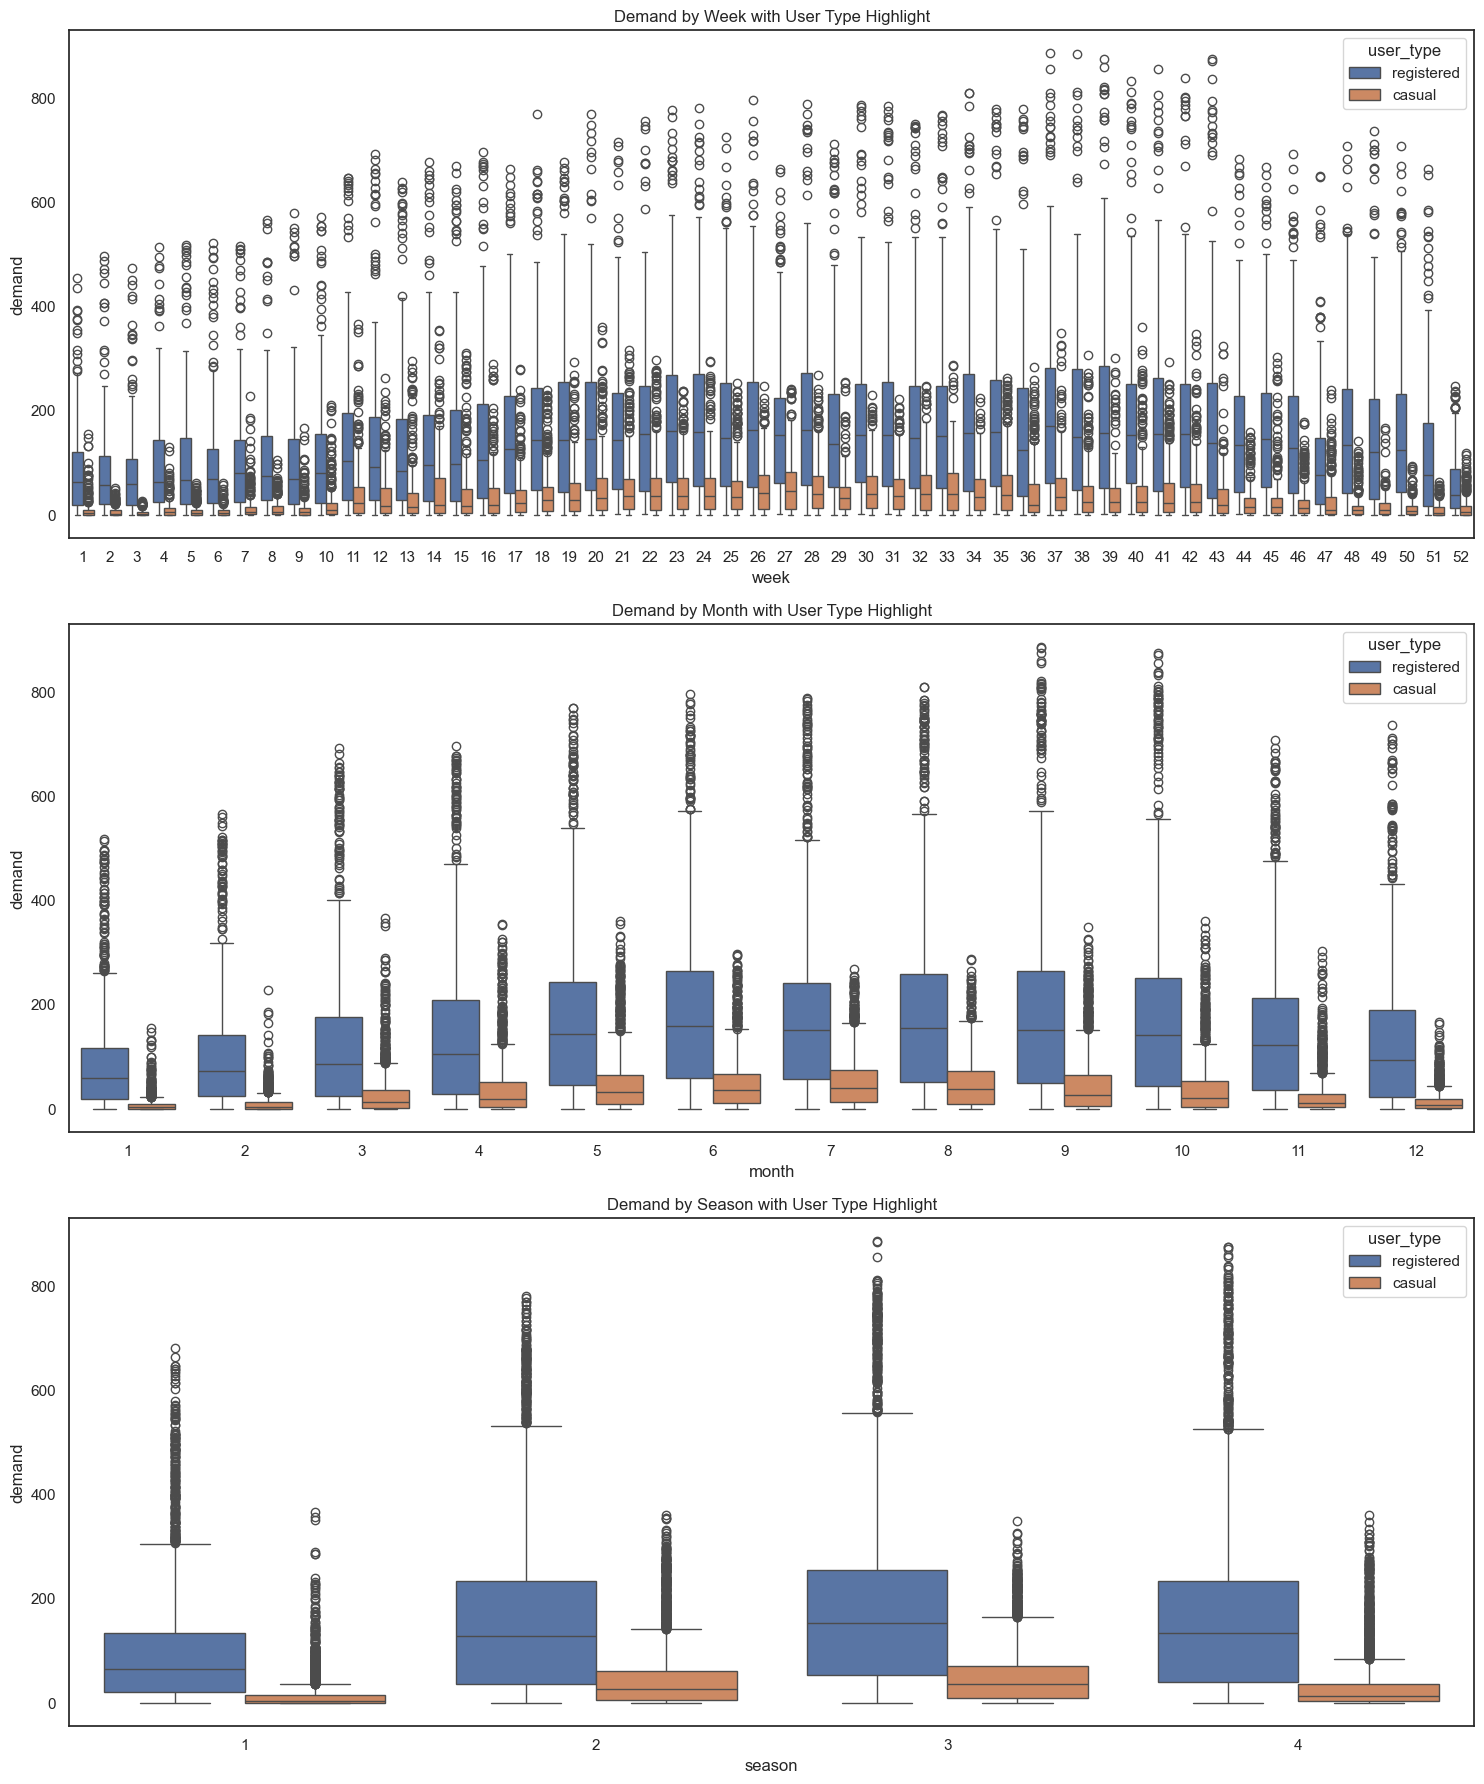

In [73]:
df_long = hour_processed_df.melt(id_vars=['week', 'month', 'season'], 
                                 value_vars=['registered', 'casual'], 
                                 var_name='user_type', value_name='demand')

fig, axes = plt.subplots(3, 1, figsize=(15, 18))  # 3 rows, 1 column

sns.boxplot(x='week', y='demand', hue='user_type', data=df_long, ax=axes[0])
axes[0].set_title('Demand by Week with User Type Highlight')

sns.boxplot(x='month', y='demand', hue='user_type', data=df_long, ax=axes[1])
axes[1].set_title('Demand by Month with User Type Highlight')

sns.boxplot(x='season', y='demand', hue='user_type', data=df_long, ax=axes[2])
axes[2].set_title('Demand by Season with User Type Highlight')

plt.tight_layout()
plt.show()


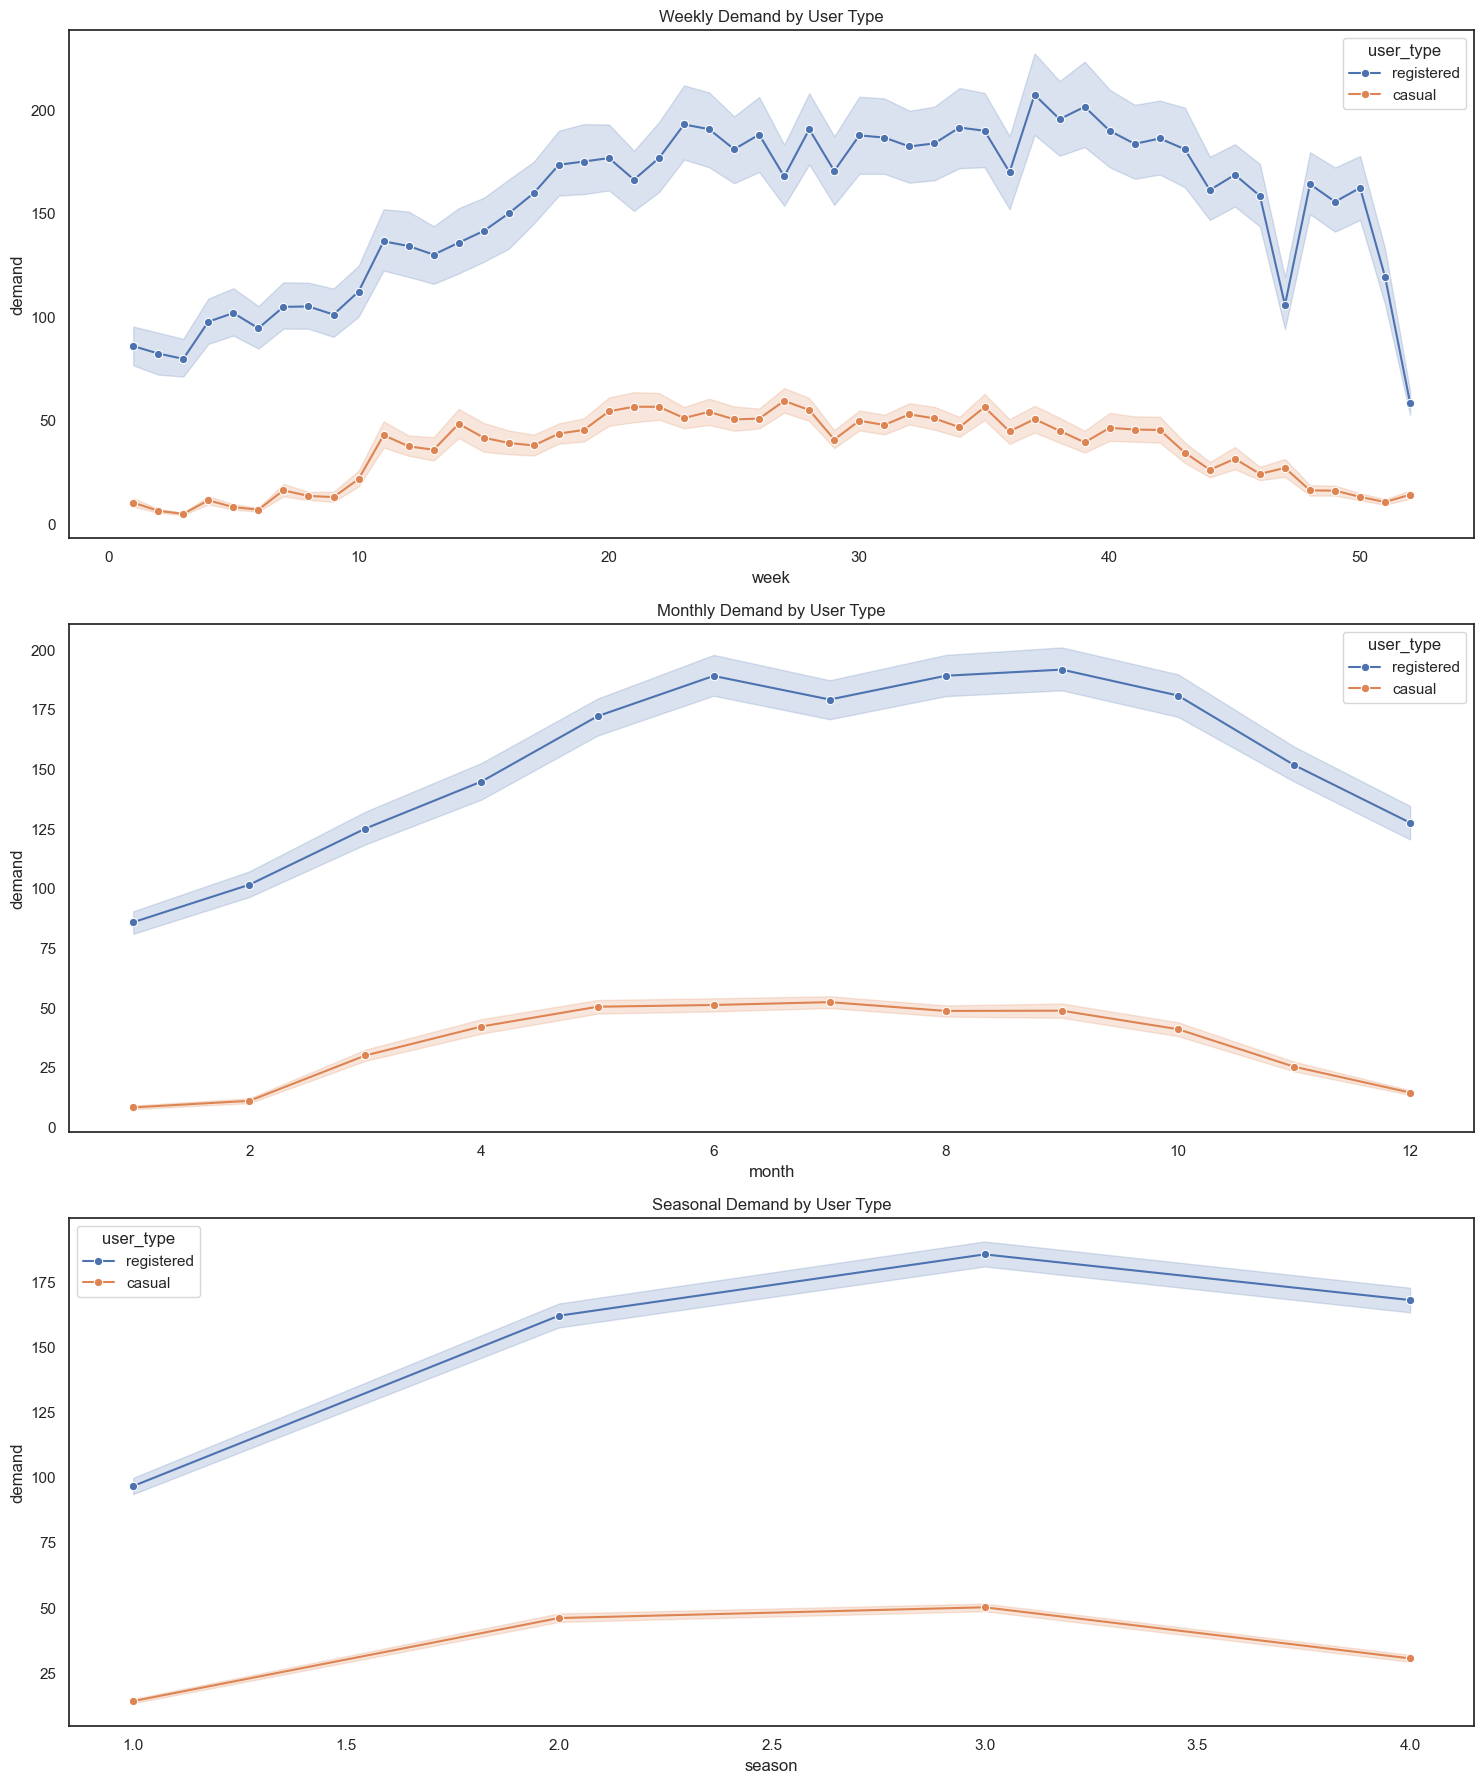

In [74]:
df_long = hour_processed_df.melt(id_vars=['week', 'month', 'season'], 
                                 value_vars=['registered', 'casual'], 
                                 var_name='user_type', value_name='demand')

fig, axes = plt.subplots(3, 1, figsize=(15, 18))  # 3 rows, 1 column

# Week-wise trend
sns.lineplot(x='week', y='demand', hue='user_type', data=df_long, ax=axes[0], marker='o')
axes[0].set_title('Weekly Demand by User Type')

# Month-wise trend
sns.lineplot(x='month', y='demand', hue='user_type', data=df_long, ax=axes[1], marker='o')
axes[1].set_title('Monthly Demand by User Type')

# Season-wise trend
sns.lineplot(x='season', y='demand', hue='user_type', data=df_long, ax=axes[2], marker='o')
axes[2].set_title('Seasonal Demand by User Type')

plt.tight_layout()
plt.show()


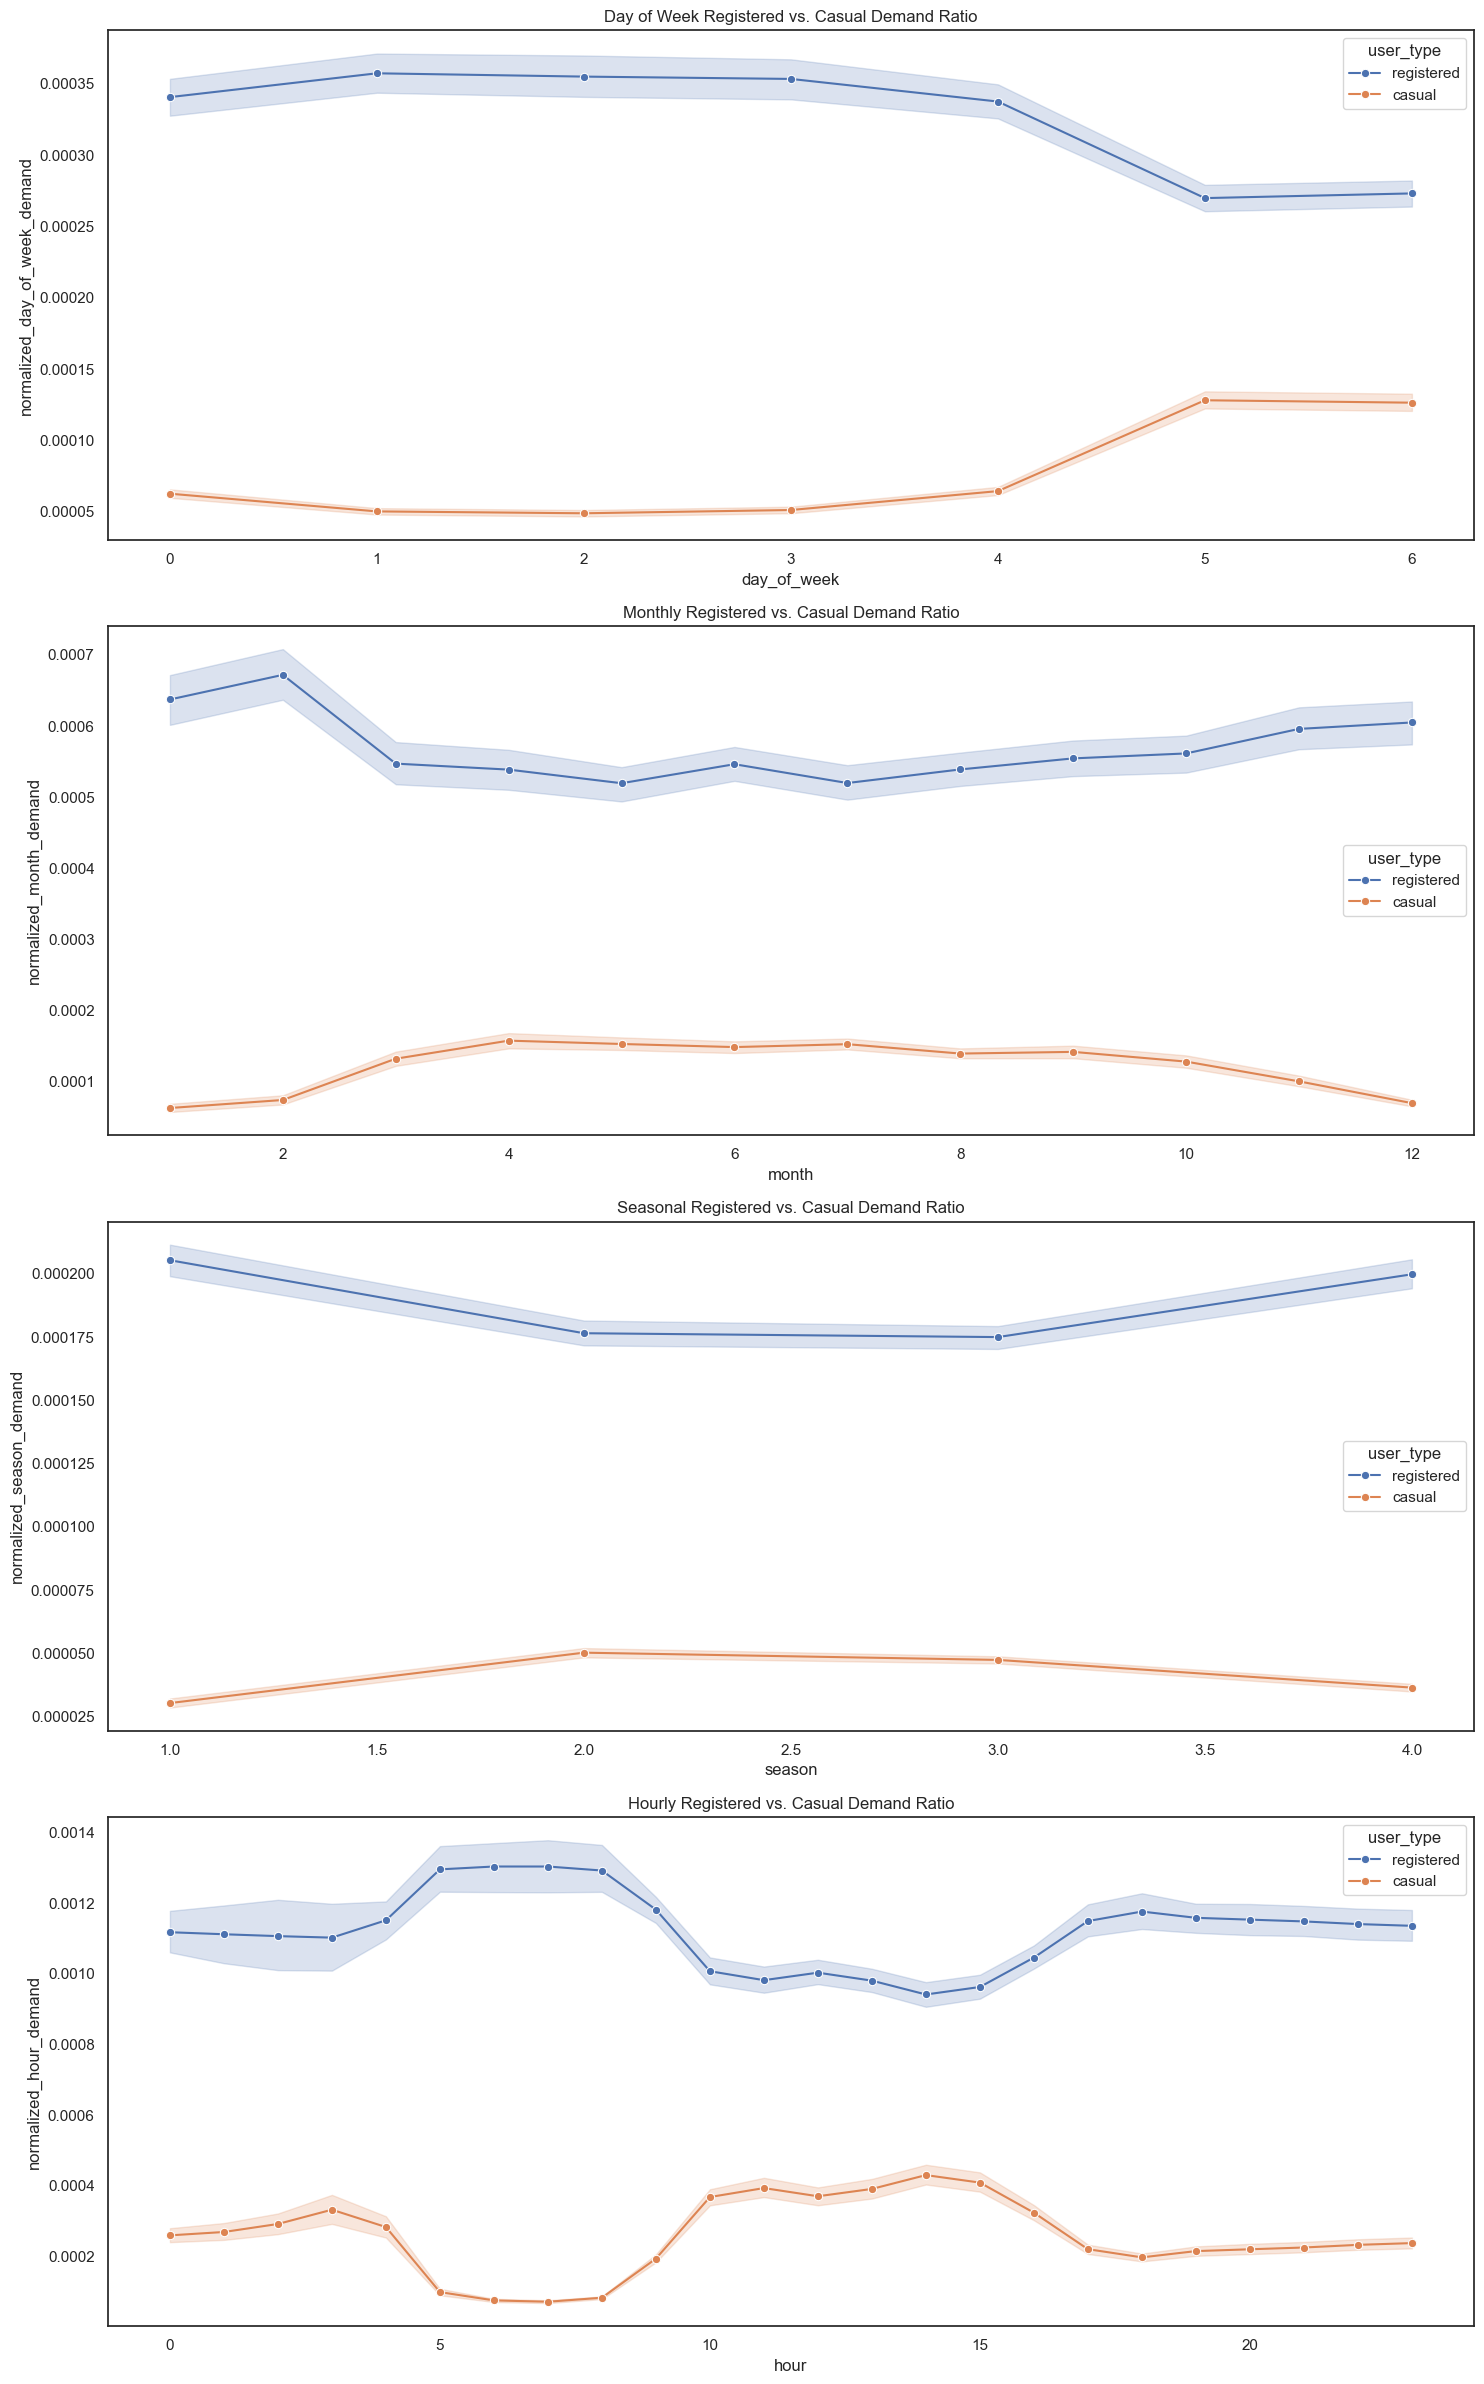

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape data (including hour)
df_long = hour_processed_df.melt(id_vars=['day_of_week', 'month', 'season', 'hour'], 
                                 value_vars=['registered', 'casual'], 
                                 var_name='user_type', value_name='demand')

# Normalize demand within each time unit
for time_unit in ['day_of_week', 'month', 'season', 'hour']:
    # Calculate total demand per group, separate for each time_unit
    df_long[f'total_{time_unit}'] = df_long.groupby(time_unit)['demand'].transform('sum')
    
    # Create a normalized demand for each time unit (scaled to [0,1])
    df_long[f'normalized_{time_unit}_demand'] = df_long['demand'] / df_long[f'total_{time_unit}']

fig, axes = plt.subplots(4, 1, figsize=(15, 24))

# day_of_week-wise trend (normalized)
sns.lineplot(x='day_of_week', y='normalized_day_of_week_demand', hue='user_type', data=df_long, ax=axes[0], marker='o')
axes[0].set_title('Day of Week Registered vs. Casual Demand Ratio')

# Month-wise trend (normalized)
sns.lineplot(x='month', y='normalized_month_demand', hue='user_type', data=df_long, ax=axes[1], marker='o')
axes[1].set_title('Monthly Registered vs. Casual Demand Ratio')

# Season-wise trend (normalized)
sns.lineplot(x='season', y='normalized_season_demand', hue='user_type', data=df_long, ax=axes[2], marker='o')
axes[2].set_title('Seasonal Registered vs. Casual Demand Ratio')

# Hour-wise trend (normalized)
sns.lineplot(x='hour', y='normalized_hour_demand', hue='user_type', data=df_long, ax=axes[3], marker='o')
axes[3].set_title('Hourly Registered vs. Casual Demand Ratio')

plt.tight_layout()
plt.show()


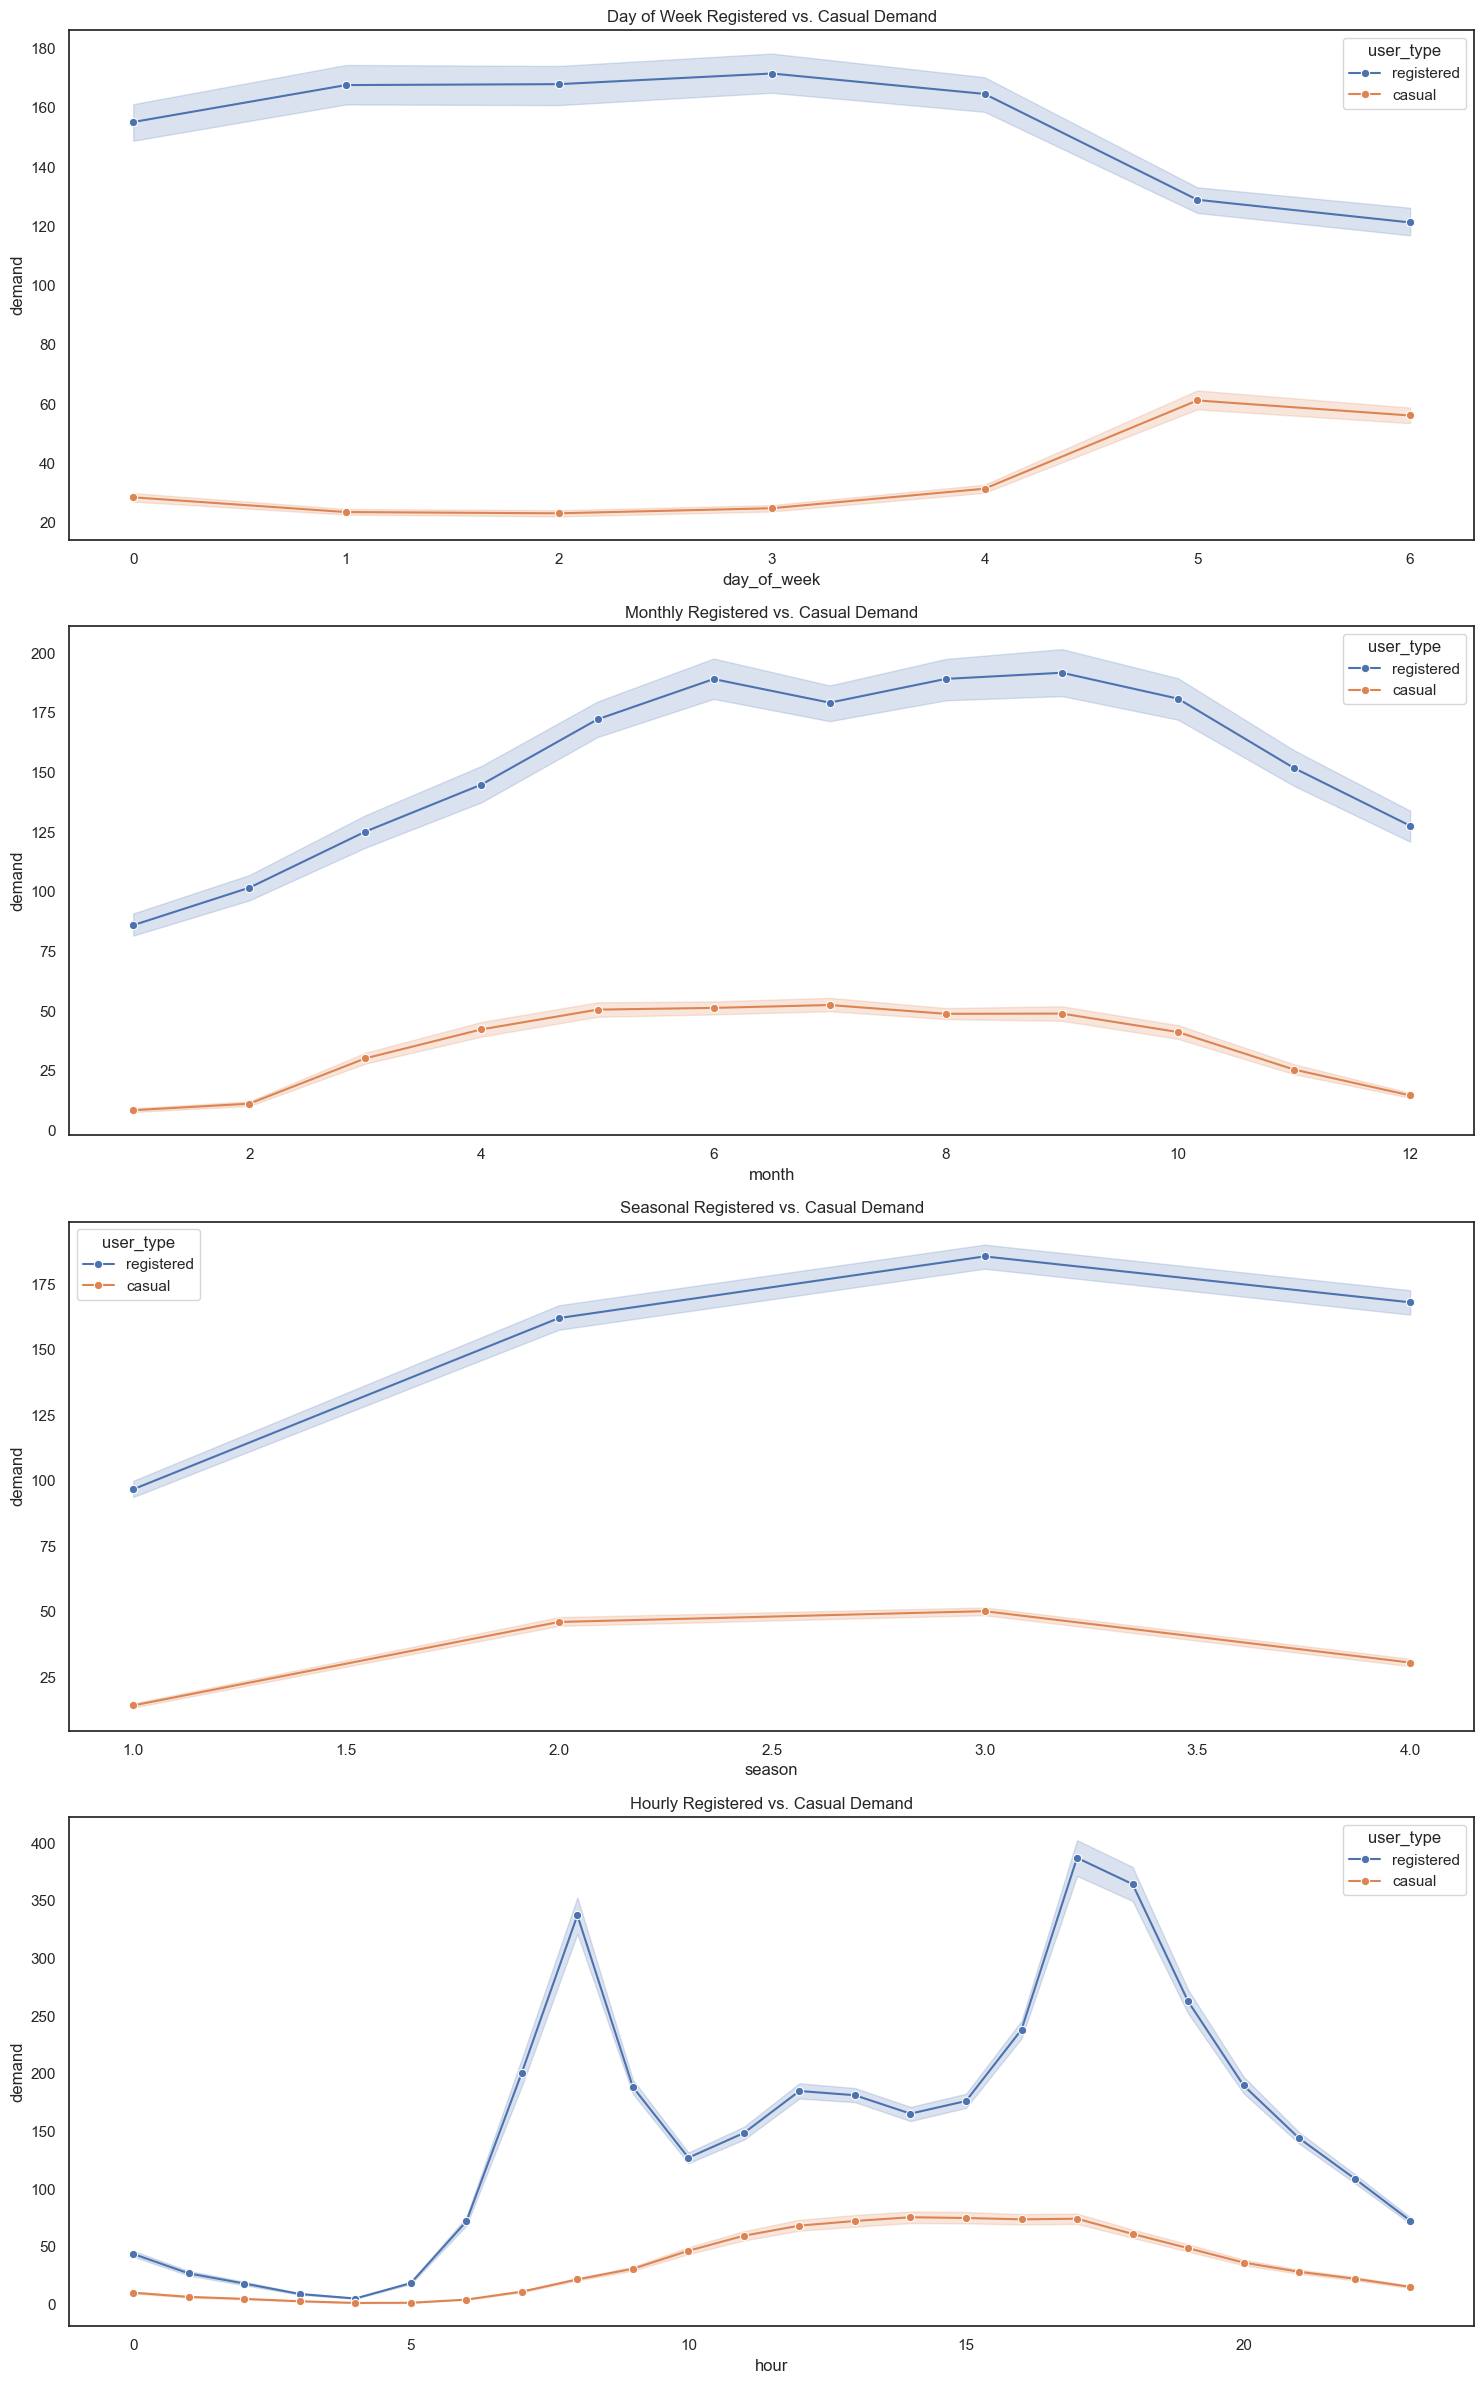

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape data (including hour)
df_long = hour_processed_df.melt(id_vars=['day_of_week', 'month', 'season', 'hour'], 
                                 value_vars=['registered', 'casual'], 
                                 var_name='user_type', value_name='demand')

fig, axes = plt.subplots(4, 1, figsize=(15, 24))

# day_of_week-wise trend (unnormalized)
sns.lineplot(x='day_of_week', y='demand', hue='user_type', data=df_long, ax=axes[0], marker='o')
axes[0].set_title('Day of Week Registered vs. Casual Demand')

# Month-wise trend (unnormalized)
sns.lineplot(x='month', y='demand', hue='user_type', data=df_long, ax=axes[1], marker='o')
axes[1].set_title('Monthly Registered vs. Casual Demand')

# Season-wise trend (unnormalized)
sns.lineplot(x='season', y='demand', hue='user_type', data=df_long, ax=axes[2], marker='o')
axes[2].set_title('Seasonal Registered vs. Casual Demand')

# Hour-wise trend (unnormalized)
sns.lineplot(x='hour', y='demand', hue='user_type', data=df_long, ax=axes[3], marker='o')
axes[3].set_title('Hourly Registered vs. Casual Demand')

plt.tight_layout()
plt.show()


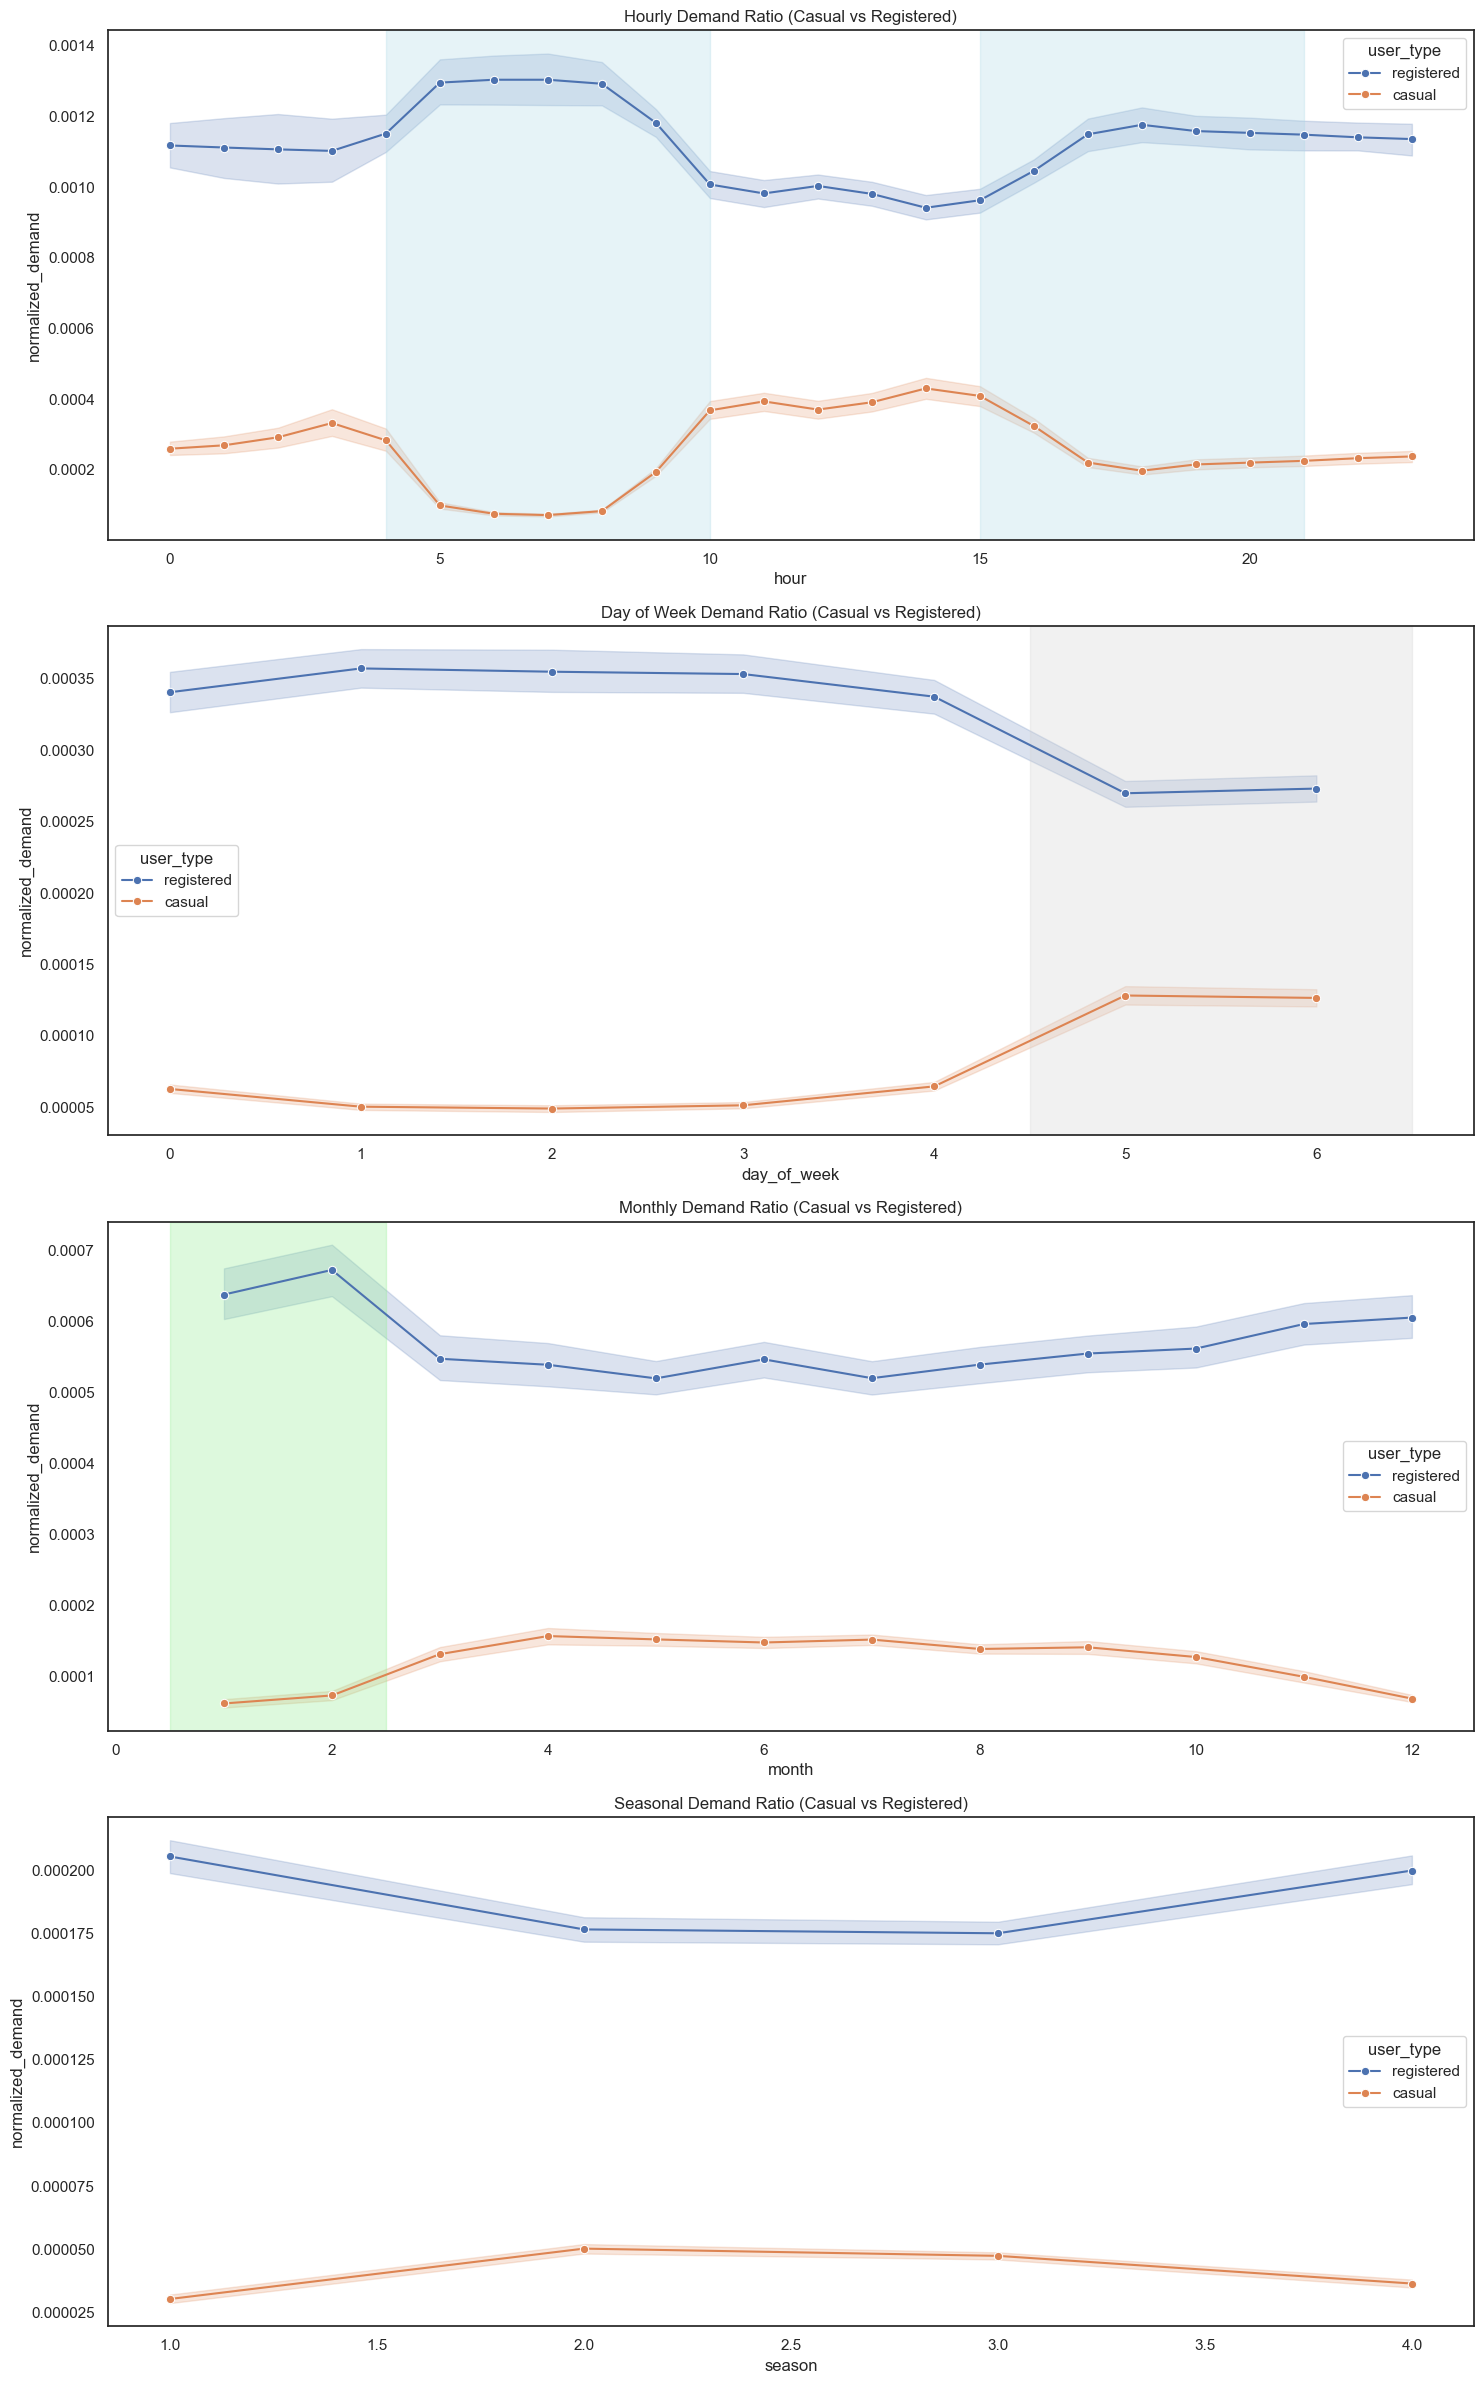

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape data including the rush_hour column so it’s available if needed
df_long = hour_processed_df.melt(
    id_vars=['day_of_week', 'month', 'season', 'hour', 'rush_hour'], 
    value_vars=['registered', 'casual'], 
    var_name='user_type', value_name='demand'
)

fig, axes = plt.subplots(4, 1, figsize=(15, 24))

# 1. Hourly Demand Ratio (with rush hour highlights)
df_hour = df_long.copy()
df_hour['normalized_demand'] = df_hour.groupby('hour')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='hour', y='normalized_demand', hue='user_type', data=df_hour, ax=axes[0], marker='o')
axes[0].set_title('Hourly Demand Ratio (Casual vs Registered)')
# Highlight rush hour periods (6–10 and 15–20)
axes[0].axvspan(4, 10, color='lightblue', alpha=0.3)
axes[0].axvspan(15, 21, color='lightblue', alpha=0.3)

# 2. Day of Week Demand Ratio (with weekend highlight)
df_day = df_long.copy()
df_day['normalized_demand'] = df_day.groupby('day_of_week')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='day_of_week', y='normalized_demand', hue='user_type', data=df_day, ax=axes[1], marker='o')
axes[1].set_title('Day of Week Demand Ratio (Casual vs Registered)')
# Highlight weekend days (assumed day_of_week 5 and 6 if Monday=0)
axes[1].axvspan(4.5, 6.5, color='lightgrey', alpha=0.3)

# 3. Monthly Demand Ratio (highlighting months 1 and 2)
df_month = df_long.copy()
df_month['normalized_demand'] = df_month.groupby('month')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='month', y='normalized_demand', hue='user_type', data=df_month, ax=axes[2], marker='o')
axes[2].set_title('Monthly Demand Ratio (Casual vs Registered)')
# Highlight months 1 and 2 (adjust the range from 0.5 to 2.5)
axes[2].axvspan(0.5, 2.5, color='lightgreen', alpha=0.3)

# 4. Seasonal Demand Ratio
df_season = df_long.copy()
df_season['normalized_demand'] = df_season.groupby('season')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='season', y='normalized_demand', hue='user_type', data=df_season, ax=axes[3], marker='o')
axes[3].set_title('Seasonal Demand Ratio (Casual vs Registered)')

plt.tight_layout()
plt.show()


In [78]:
hour_processed_df.columns

Index(['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'count', 'timestamp', 'payday', 'day', 'day_of_week',
       'day_of_month', 'week', 'year_sin', 'year_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'working_day', 'weekend', 'moonphase', 'quarter', 'christmas',
       'day_of_year', 'rush_hour'],
      dtype='object')

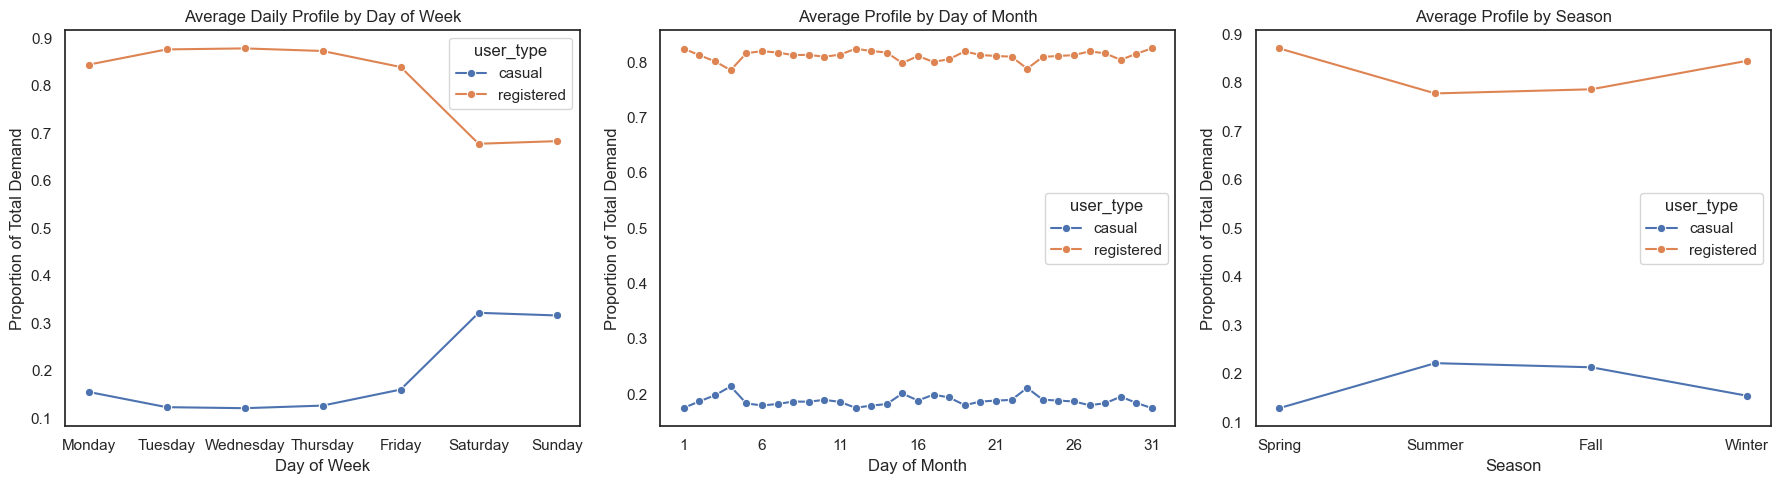

In [79]:
# Plot for day of month
df_day = hour_processed_df.melt(id_vars=['day_of_week'], 
                                value_vars=['registered', 'casual'], 
                                var_name='user_type', value_name='demand')
df_day_avg = df_day.groupby(['day_of_week', 'user_type'])['demand'].mean().reset_index()
df_day_avg['total_demand'] = df_day_avg.groupby('day_of_week')['demand'].transform('sum')
df_day_avg['normalized_demand'] = df_day_avg['demand'] / df_day_avg['total_demand']

# Plot for month of year
df_month = hour_processed_df.melt(id_vars=['day_of_month'], 
                                  value_vars=['registered', 'casual'], 
                                  var_name='user_type', value_name='demand')
df_month_avg = df_month.groupby(['day_of_month', 'user_type'])['demand'].mean().reset_index()
df_month_avg['total_demand'] = df_month_avg.groupby('day_of_month')['demand'].transform('sum')
df_month_avg['normalized_demand'] = df_month_avg['demand'] / df_month_avg['total_demand']

# Plot for season of year
df_season = hour_processed_df.melt(id_vars=['season'], 
                                   value_vars=['registered', 'casual'], 
                                   var_name='user_type', value_name='demand')
df_season_avg = df_season.groupby(['season', 'user_type'])['demand'].mean().reset_index()
df_season_avg['total_demand'] = df_season_avg.groupby('season')['demand'].transform('sum')
df_season_avg['normalized_demand'] = df_season_avg['demand'] / df_season_avg['total_demand']

# Assuming your data (`df_day_avg`, `df_month_avg`, `df_season_avg`) is correct

plt.figure(figsize=(18, 5))

# Day of Week plot
plt.subplot(1, 3, 1)
sns.lineplot(x='day_of_week', y='normalized_demand', hue='user_type', data=df_day_avg, marker='o')
plt.title('Average Daily Profile by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Proportion of Total Demand')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Day of Month plot
plt.subplot(1, 3, 2)
sns.lineplot(x='day_of_month', y='normalized_demand', hue='user_type', data=df_month_avg, marker='o')
plt.title('Average Profile by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Proportion of Total Demand')
plt.xticks(ticks=range(1, 32, 5))  # Show ticks for every 5th day (can adjust based on your data)

# Season plot
plt.subplot(1, 3, 3)
sns.lineplot(x='season', y='normalized_demand', hue='user_type', data=df_season_avg, marker='o')
plt.title('Average Profile by Season')
plt.xlabel('Season')
plt.ylabel('Proportion of Total Demand')
plt.xticks(ticks=[1, 2, 3, 4], labels=['Spring', 'Summer', 'Fall', 'Winter'])

plt.tight_layout()
plt.show()



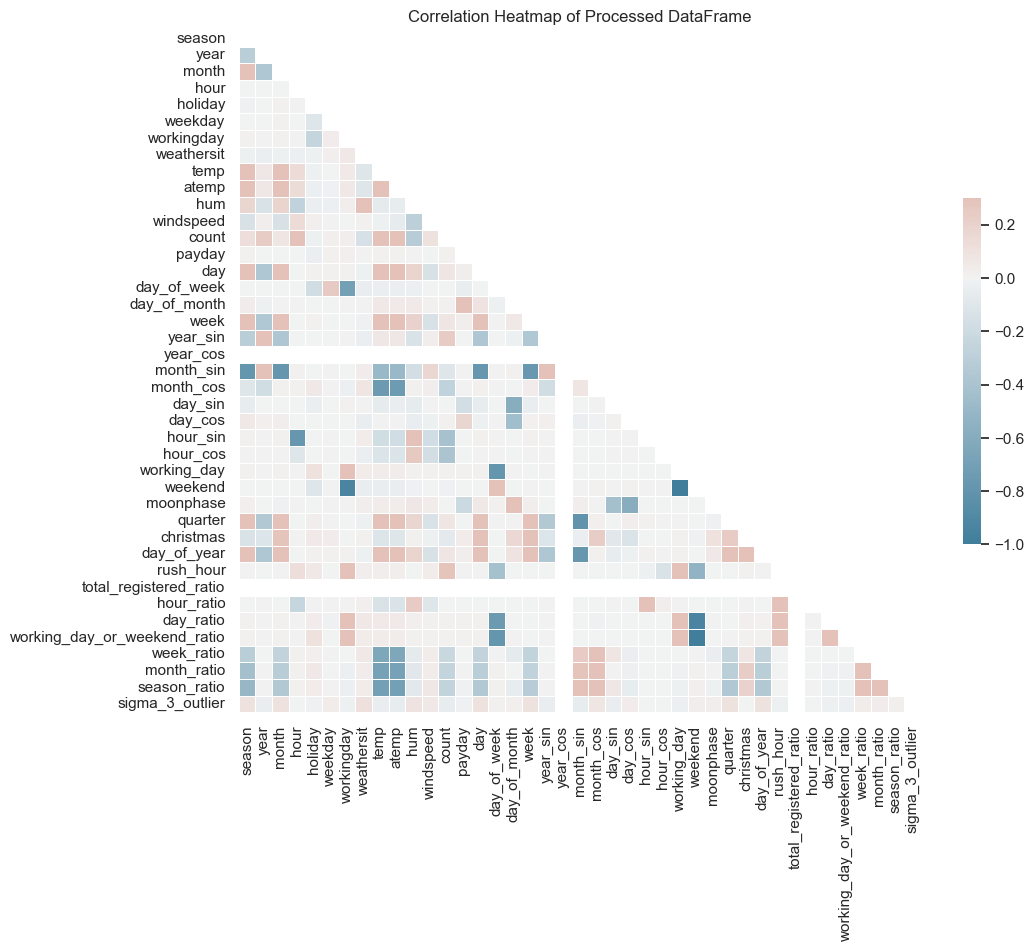

In [80]:
train_df_numeric = train_df.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

sns.set_theme(style="white")

corr = train_df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Processed DataFrame')
plt.show()

2025-03-08 17:42:13,177 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:13,198 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


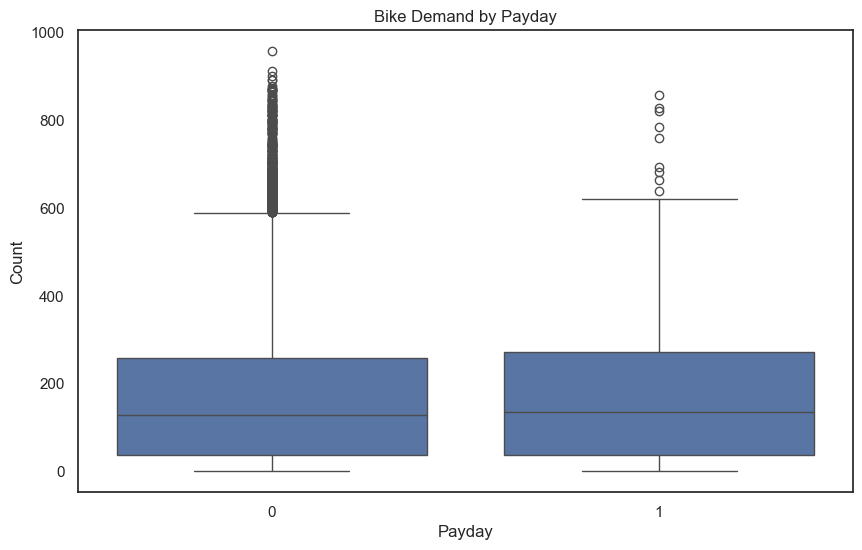

In [81]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='payday', y='count', data=train_df)
plt.title('Bike Demand by Payday')
plt.xlabel('Payday')
plt.ylabel('Count')
plt.show()

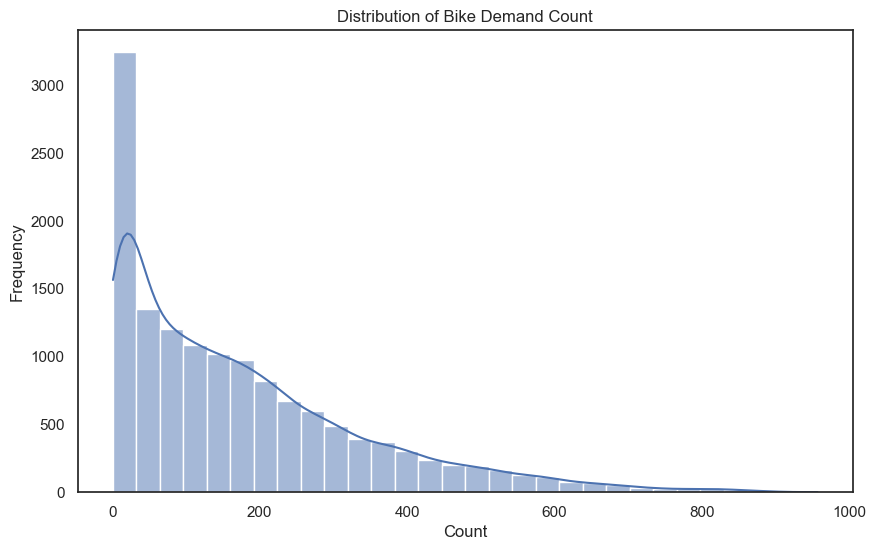

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['count'], bins=30, kde=True)
plt.title('Distribution of Bike Demand Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

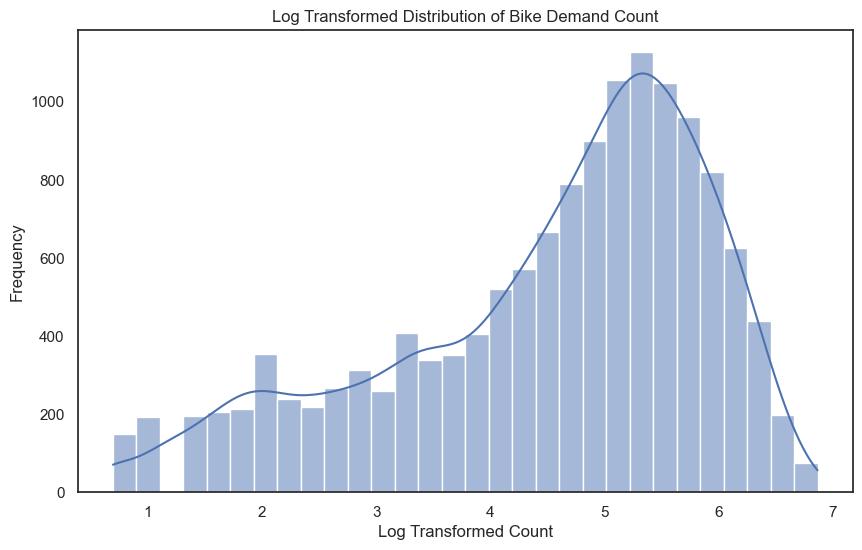

In [83]:
# Apply log transformation
count_log = np.log1p(train_df['count'])  # Use log1p to handle zero values

plt.figure(figsize=(10, 6))
sns.histplot(count_log, bins=30, kde=True)
plt.title('Log Transformed Distribution of Bike Demand Count')
plt.xlabel('Log Transformed Count')
plt.ylabel('Frequency')
plt.show()

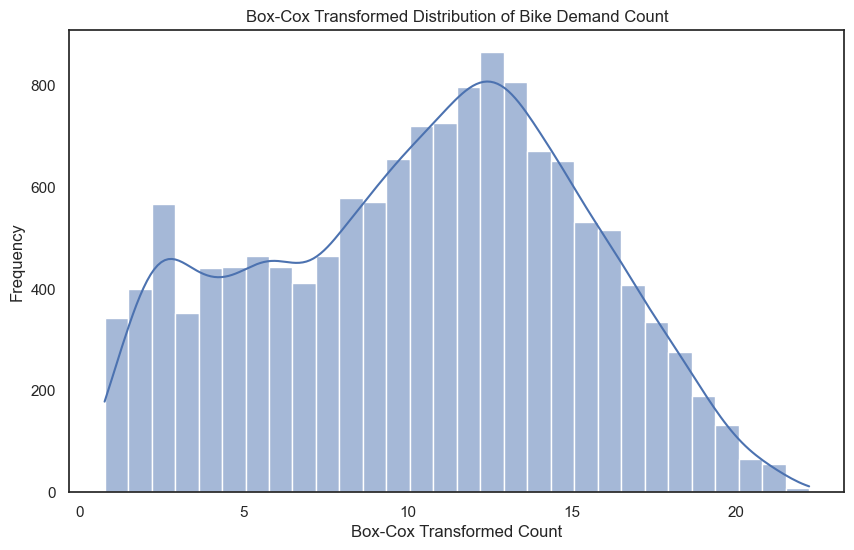

In [84]:
from scipy import stats

# Apply Box-Cox transformation
count_boxcox, _ = stats.boxcox(train_df['count'] + 1)  # Adding 1 to avoid zero values

plt.figure(figsize=(10, 6))
sns.histplot(count_boxcox, bins=30, kde=True)
plt.title('Box-Cox Transformed Distribution of Bike Demand Count')
plt.xlabel('Box-Cox Transformed Count')
plt.ylabel('Frequency')
plt.show()

2025-03-08 17:42:14,839 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:14,863 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:15,168 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:15,189 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:15,716 - INFO - Using categorical units to plot a list of strings that are all parsable as 

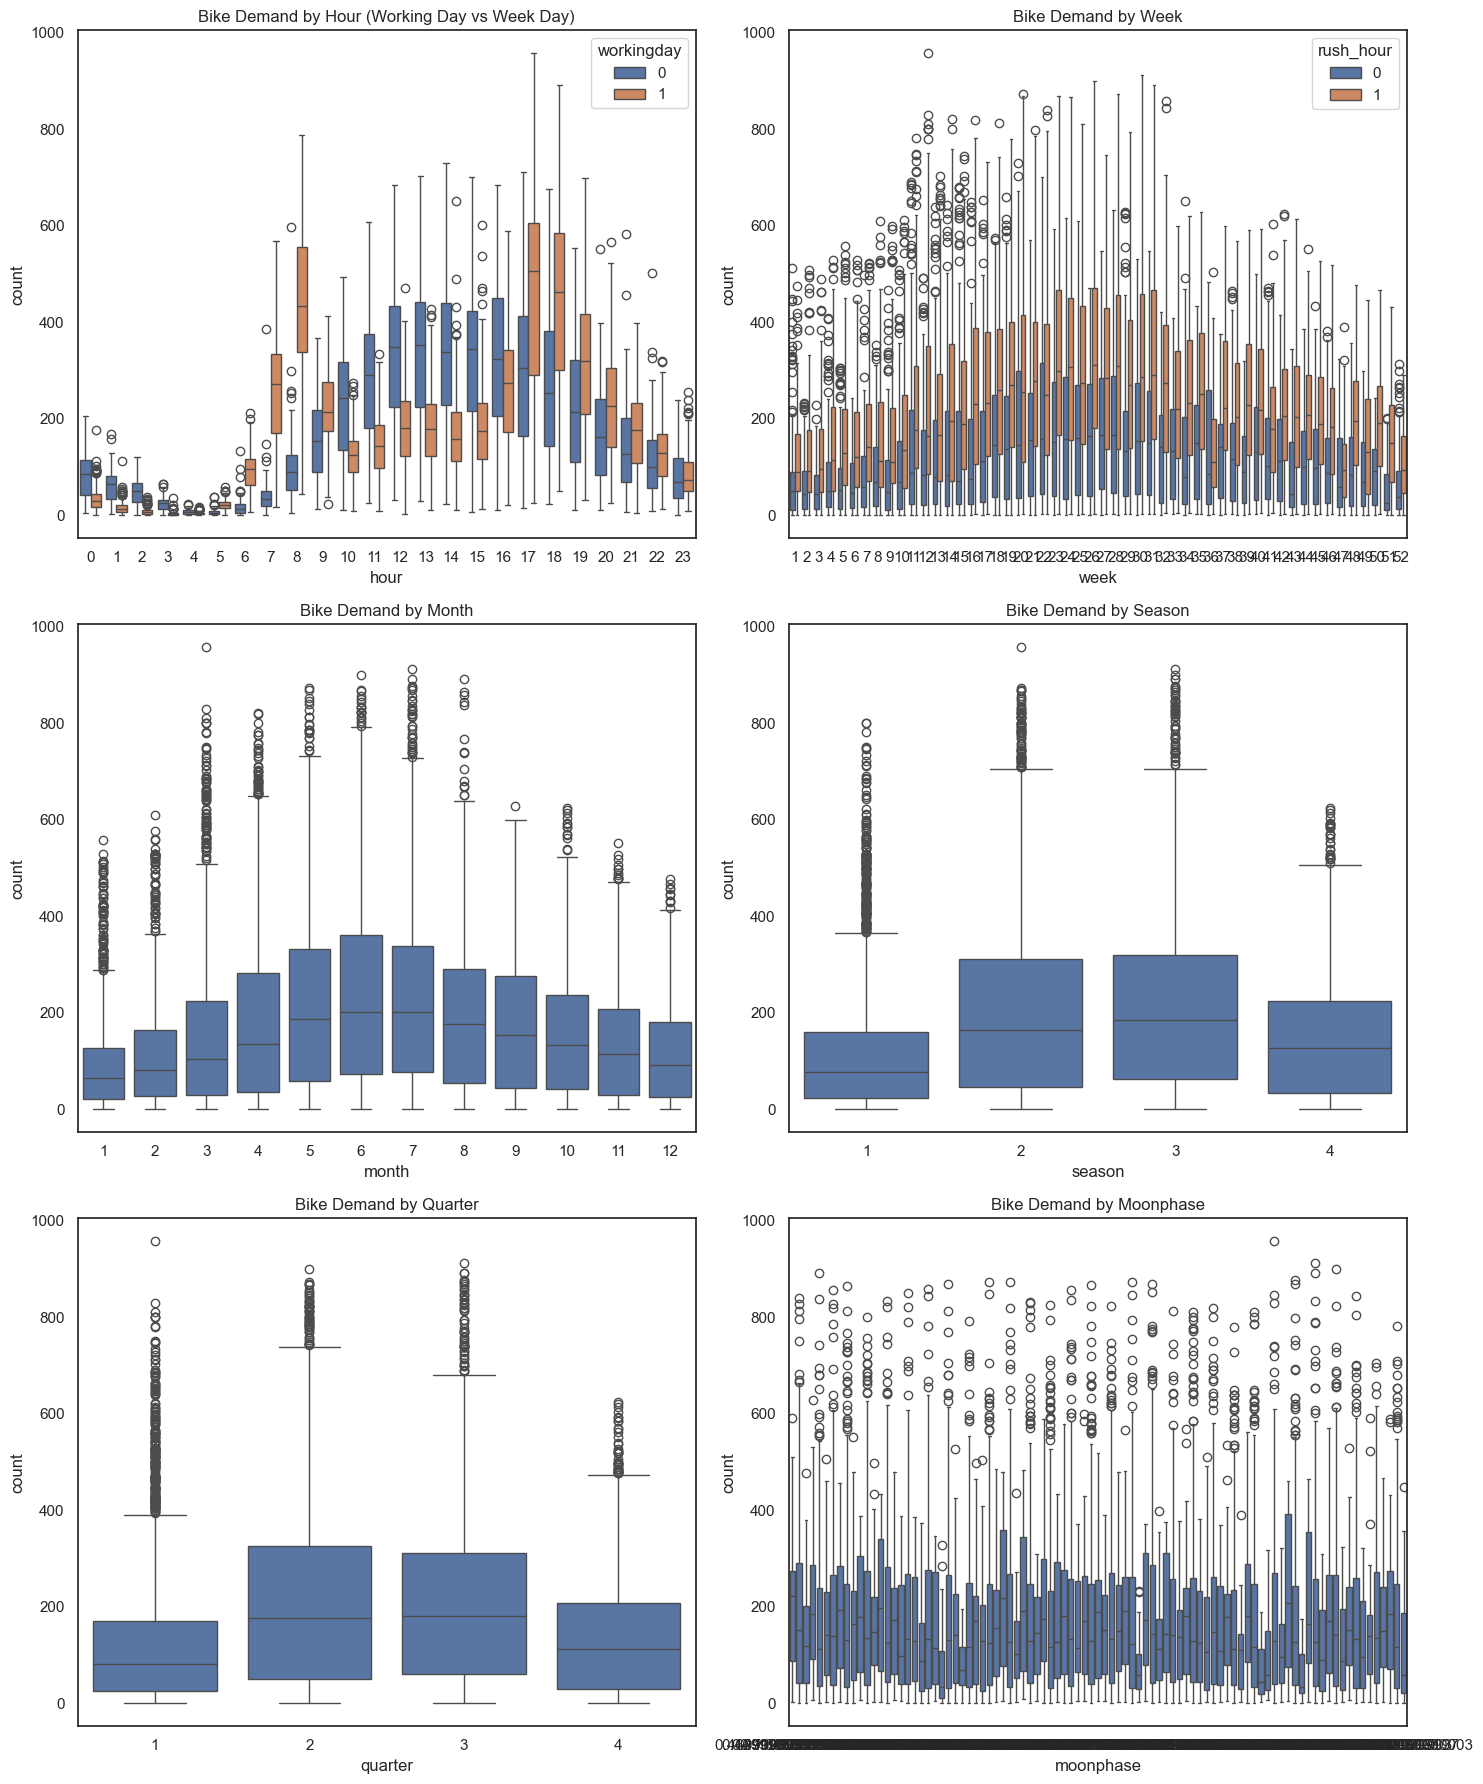

In [85]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Hour grouping
sns.boxplot(x='hour', y='count', hue='workingday', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Bike Demand by Hour (Working Day vs Week Day)')

# Week grouping
sns.boxplot(x='week', y='count', hue='rush_hour', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Bike Demand by Week')

# Month grouping
sns.boxplot(x='month', y='count', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Bike Demand by Month')

# Season grouping
sns.boxplot(x='season', y='count', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('Bike Demand by Season')

# Quarter grouping
sns.boxplot(x='quarter', y='count', data=train_df, ax=axes[2, 0])
axes[2, 0].set_title('Bike Demand by Quarter')

# Moonphase grouping
sns.boxplot(x='moonphase', y='count', data=train_df, ax=axes[2, 1])
axes[2, 1].set_title('Bike Demand by Moonphase')

plt.tight_layout()
plt.show()

2025-03-08 17:42:19,844 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:19,867 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


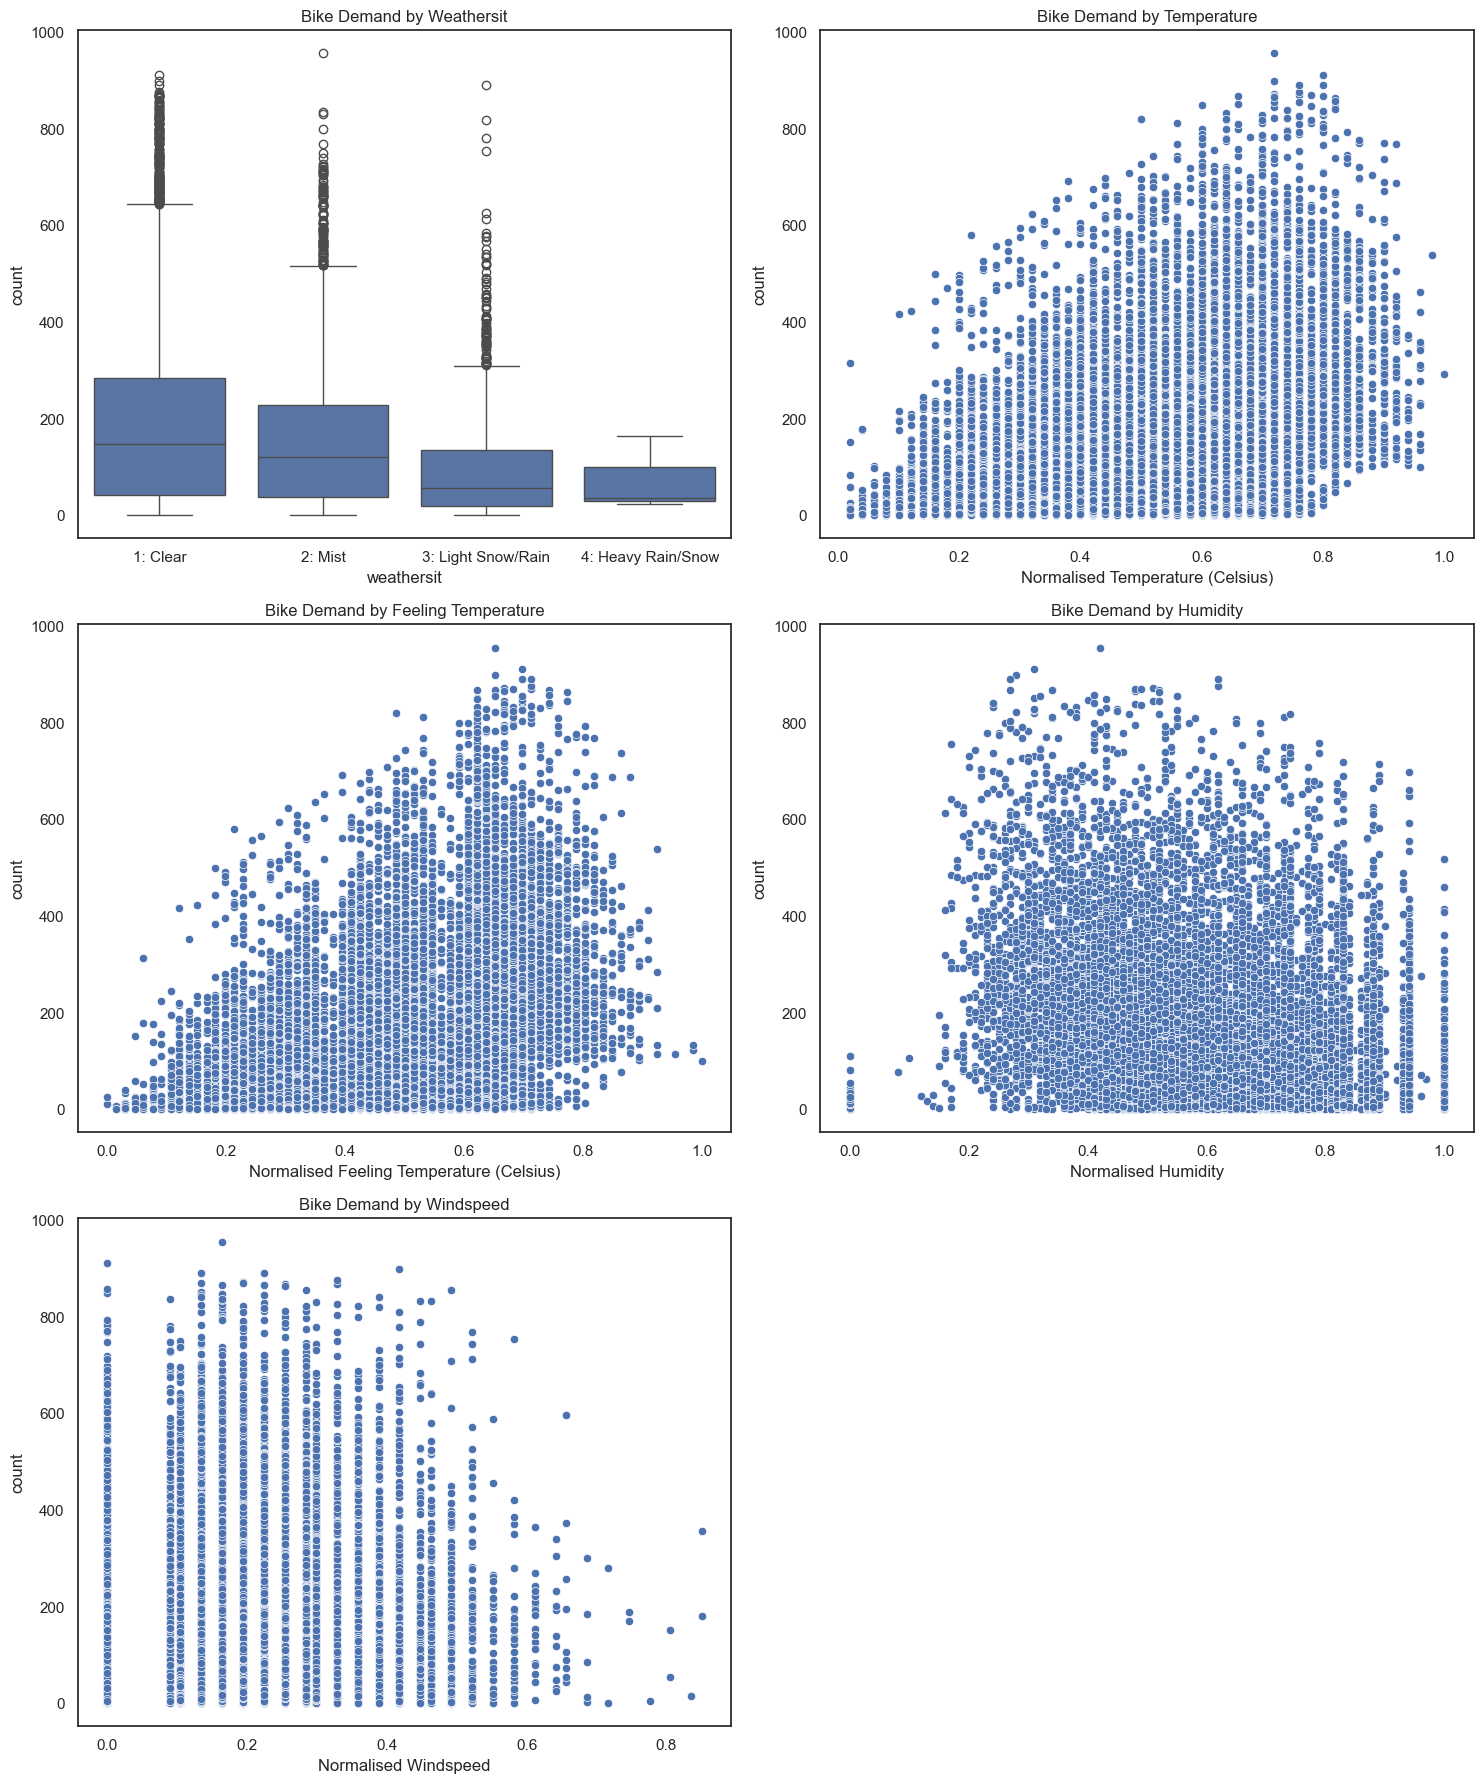

In [86]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

sns.boxplot(x='weathersit', y='count', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Bike Demand by Weathersit')
axes[0, 0].set_xticks([0, 1, 2, 3])
axes[0, 0].set_xticklabels(['1: Clear', '2: Mist', '3: Light Snow/Rain', '4: Heavy Rain/Snow'])

sns.scatterplot(x='temp', y='count', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Bike Demand by Temperature')
axes[0, 1].set_xlabel('Normalised Temperature (Celsius)')

sns.scatterplot(x='atemp', y='count', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Bike Demand by Feeling Temperature')
axes[1, 0].set_xlabel('Normalised Feeling Temperature (Celsius)')

sns.scatterplot(x='hum', y='count', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('Bike Demand by Humidity')
axes[1, 1].set_xlabel('Normalised Humidity')

sns.scatterplot(x='windspeed', y='count', data=train_df, ax=axes[2, 0])
axes[2, 0].set_title('Bike Demand by Windspeed')
axes[2, 0].set_xlabel('Normalised Windspeed')

axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

2025-03-08 17:42:21,577 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:21,602 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:21,709 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-03-08 17:42:21,774 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:21,978 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:22,003 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:22,102 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-08 17:42:22,121 - INFO - Using categorical units to plot a list of strings that are all parsable as 

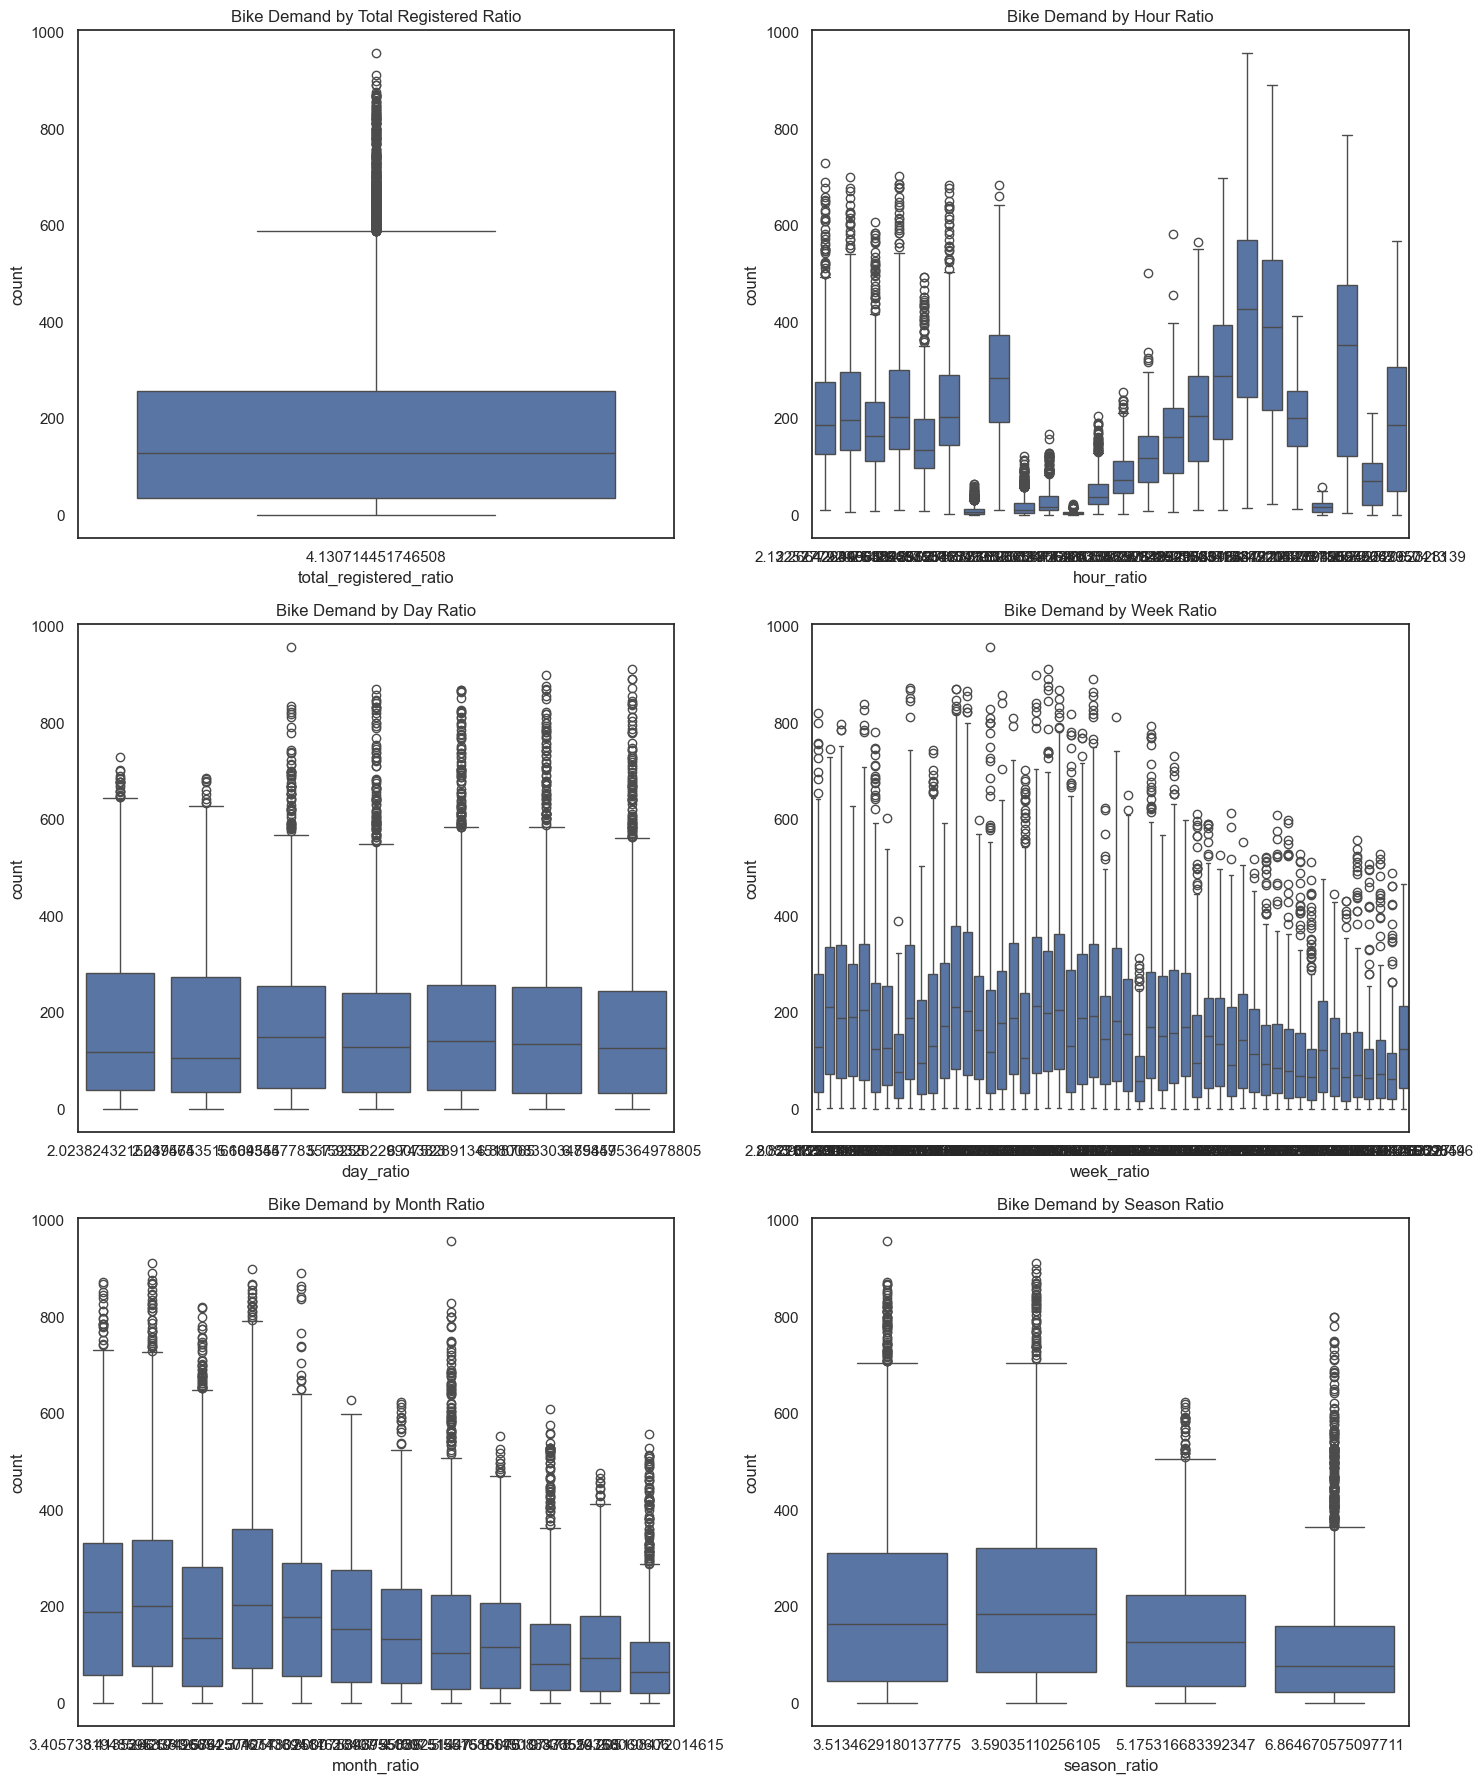

In [87]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Total Registered Ratio
sns.boxplot(x='total_registered_ratio', y='count', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Bike Demand by Total Registered Ratio')

# Hour Ratio
sns.boxplot(x='hour_ratio', y='count', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Bike Demand by Hour Ratio')

# Day Ratio
sns.boxplot(x='day_ratio', y='count', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Bike Demand by Day Ratio')

# Week Ratio
sns.boxplot(x='week_ratio', y='count', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('Bike Demand by Week Ratio')

# Month Ratio
sns.boxplot(x='month_ratio', y='count', data=train_df, ax=axes[2, 0])
axes[2, 0].set_title('Bike Demand by Month Ratio')

# Season Ratio
sns.boxplot(x='season_ratio', y='count', data=train_df, ax=axes[2, 1])
axes[2, 1].set_title('Bike Demand by Season Ratio')

plt.tight_layout()
plt.show()

In [88]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df.drop(columns=['count']))

# Define the Isolation Forest model with tuned hyperparameters
iso_forest = IsolationForest(n_estimators=200, max_samples='auto', contamination=0.01, max_features=1.0, random_state=42, n_jobs=-1)

# Fit the model to the scaled training data
iso_forest.fit(train_df_scaled)

# Predict the outliers
outliers = iso_forest.predict(train_df_scaled)

# Filter out the outliers
train_df_cleaned = train_df[outliers == 1]

# Display the cleaned training data
train_df_cleaned

season  year  month  hour  holiday  weekday  workingday  weathersit  \
0           1  2011      1     0        0        6           0           1   
1           1  2011      1     1        0        6           0           1   
2           1  2011      1     2        0        6           0           1   
3           1  2011      1     3        0        6           0           1   
4           1  2011      1     4        0        6           0           1   
...       ...   ...    ...   ...      ...      ...         ...         ...   
13898       3  2012      8     7        0        2           1           2   
13899       3  2012      8     8        0        2           1           2   
13900       3  2012      8     9        0        2           1           2   
13901       3  2012      8    10        0        2           1           2   
13902       3  2012      8    11        0        2           1           2   

       temp   atemp  ...  day_of_year  rush_hour  total_registered_ratio  \
0      0.24  0.2879  ...            1          0                4.130714   
1      0.22  0.2727  ...            1          0                4.130714   
2      0.22  0.2727  ...            1          0                4.130714   
3      0.24  0.2879  ...            1          0                4.130714   
4      0.24  0.2879  ...            1          0                4.130714   
...     ...     ...  ...          ...        ...                     ...   
13898  0.70  0.6667  ...          220          1                4.130714   
13899  0.70  0.6515  ...          220          1                4.130714   
13900  0.70  0.6667  ...          220          1                4.130714   
13901  0.74  0.6970  ...          220          1                4.130714   
13902  0.76  0.7273  ...          220          0                4.130714   

       hour_ratio  day_ratio  working_day_or_weekend_ratio  week_ratio  \
0        3.956203   2.023824                      2.031464    4.011357   
1        3.820755   2.023824                      2.031464    4.011357   
2        3.516366   2.023824                      2.031464    4.011357   
3        3.037884   2.023824                      2.031464    4.011357   
4        3.824773   2.023824                      2.031464    4.011357   
...           ...        ...                           ...         ...   
13898   16.252521   6.880083                      6.054939    3.580079   
13899   14.472150   6.880083                      6.054939    3.580079   
13900    5.872119   6.880083                      6.054939    3.580079   
13901    2.638569   6.880083                      6.054939    3.580079   
13902    2.426399   6.880083                      6.054939    3.580079   

       month_ratio  season_ratio  sigma_3_outlier  
0        10.205198      6.864671            False  
1        10.205198      6.864671            False  
2        10.205198      6.864671            False  
3        10.205198      6.864671            False  
4        10.205198      6.864671            False  
...            ...           ...              ...  
13898     3.767437      3.590351            False  
13899     3.767437      3.590351            False  
13900     3.767437      3.590351            False  
13901     3.767437      3.590351            False  
13902     3.767437      3.590351            False  

[13763 rows x 41 columns]

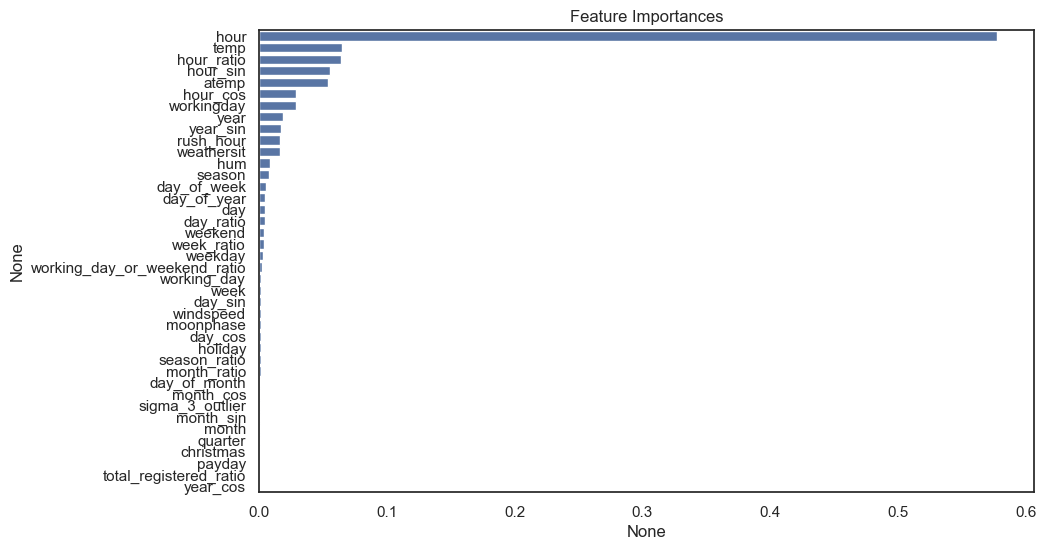

In [89]:
from scipy.stats import boxcox

model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_depth=10, random_state=42)

X_train = train_df.drop(columns=['count'])

# Apply Box-Cox
y_train, lambda_value = boxcox(train_df['count'] + 1)  # Add 1 if you have zero values
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title('Feature Importances')
plt.show()

Root Mean Squared Error: 90.28225416160818
R^2 Score: 0.8323330707036224


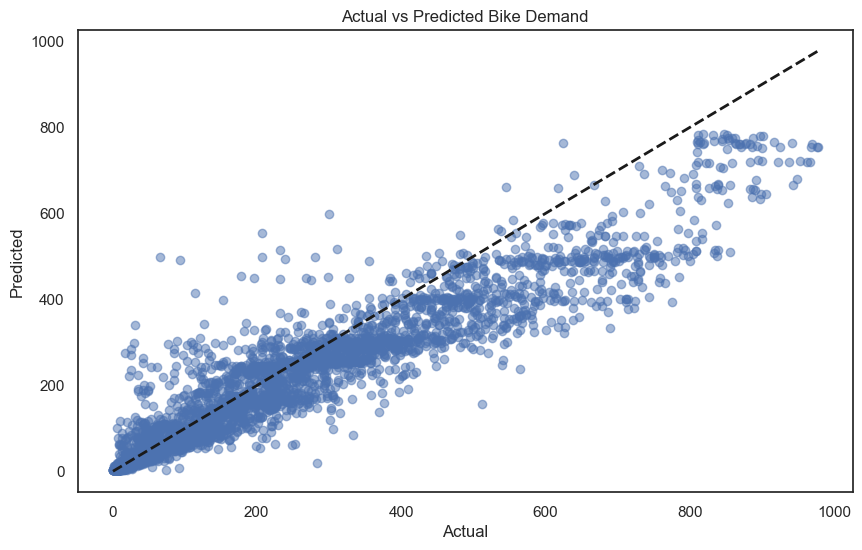

In [90]:
X_val = val_df.drop(columns=['count'])
y_val = val_df['count']

def inverse_boxcox(y_transformed, lambda_value):
    return (y_transformed * lambda_value + 1) ** (1 / lambda_value) - 1 if lambda_value != 0 else np.exp(y_transformed) - 1

y_pred = inverse_boxcox(model.predict(X_val), lambda_value)

rmse = mean_squared_error(y_val, y_pred) ** 0.5
r2 = r2_score(y_val, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Bike Demand')
plt.show()

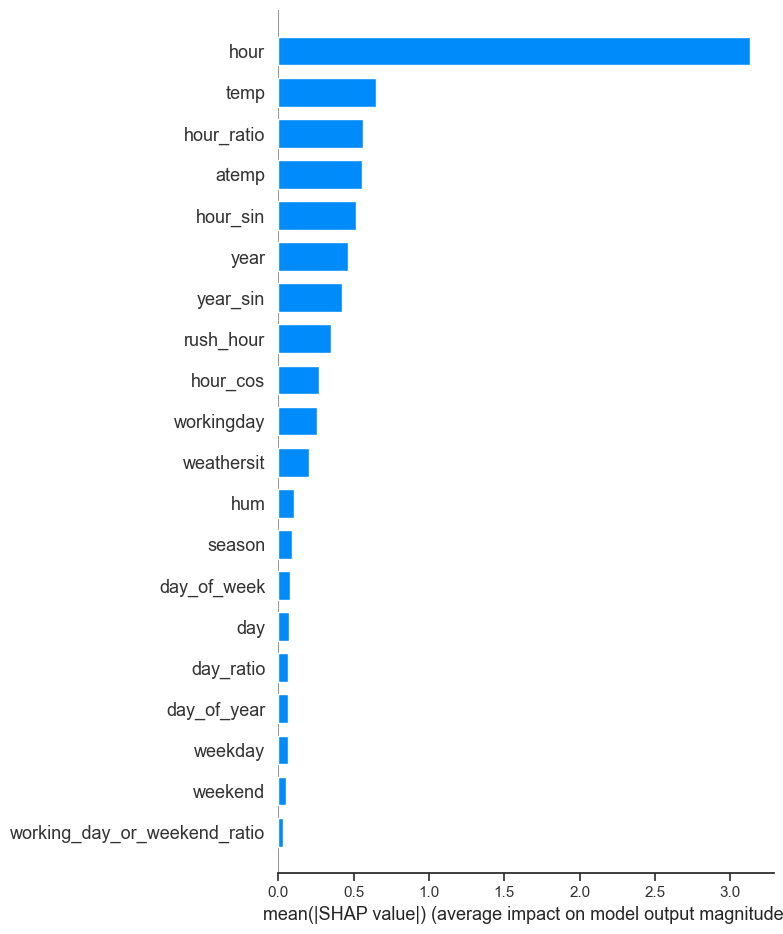

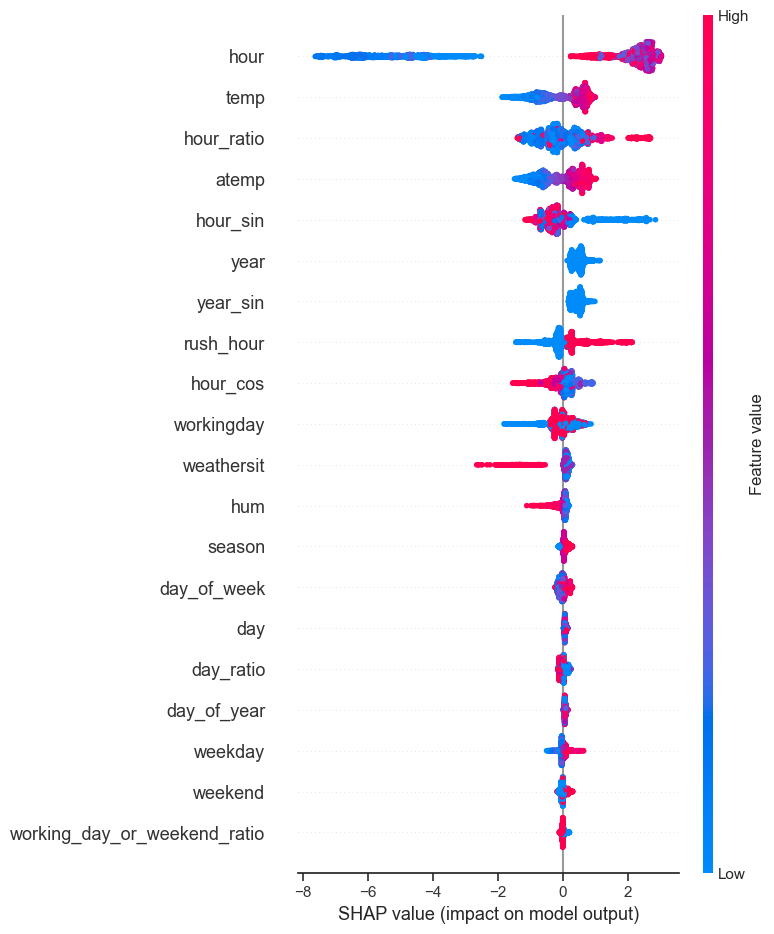

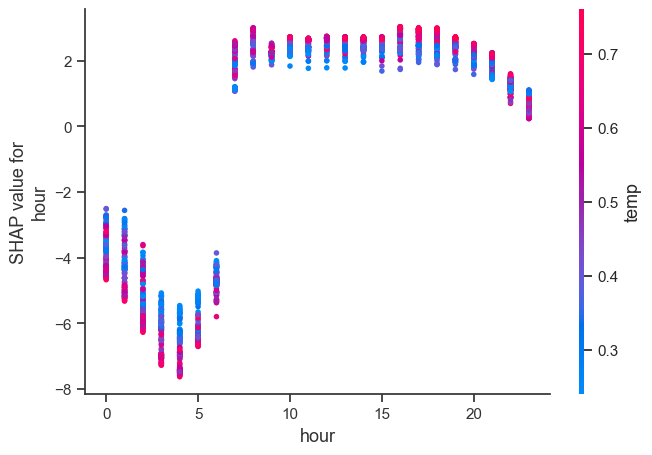

In [91]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

shap.summary_plot(shap_values, X_val)

shap.dependence_plot("hour", shap_values, X_val)

shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0, :], X_val.iloc[0, :])

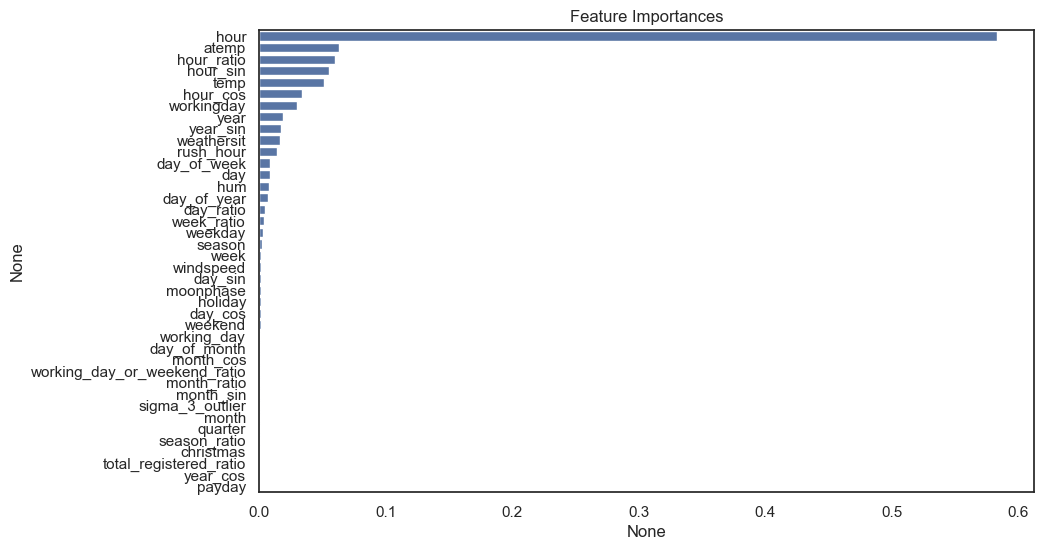

In [92]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_depth=10, random_state=42)

X_train = train_df_cleaned.drop(columns=['count'])
y_train, lambda_value = boxcox(train_df_cleaned['count'] + 1)  # Add 1 if you have zero values
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title('Feature Importances')
plt.show()

Root Mean Squared Error: 89.29079290724799
R^2 Score: 0.8359954179662413


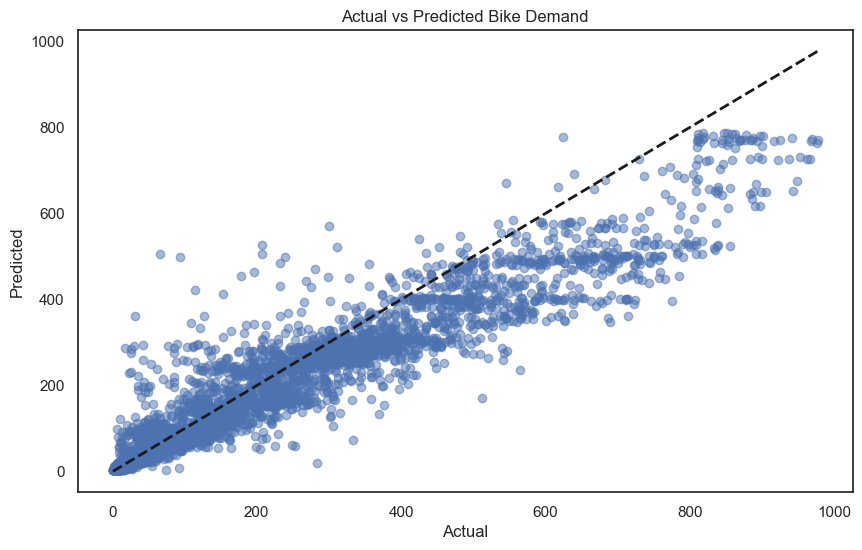

In [93]:
X_val = val_df.drop(columns=['count'])
y_val = val_df['count']

def inverse_boxcox(y_transformed, lambda_value):
    return (y_transformed * lambda_value + 1) ** (1 / lambda_value) - 1 if lambda_value != 0 else np.exp(y_transformed) - 1

y_pred = inverse_boxcox(model.predict(X_val), lambda_value)

rmse = mean_squared_error(y_val, y_pred) ** 0.5
r2 = r2_score(y_val, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Bike Demand')
plt.show()

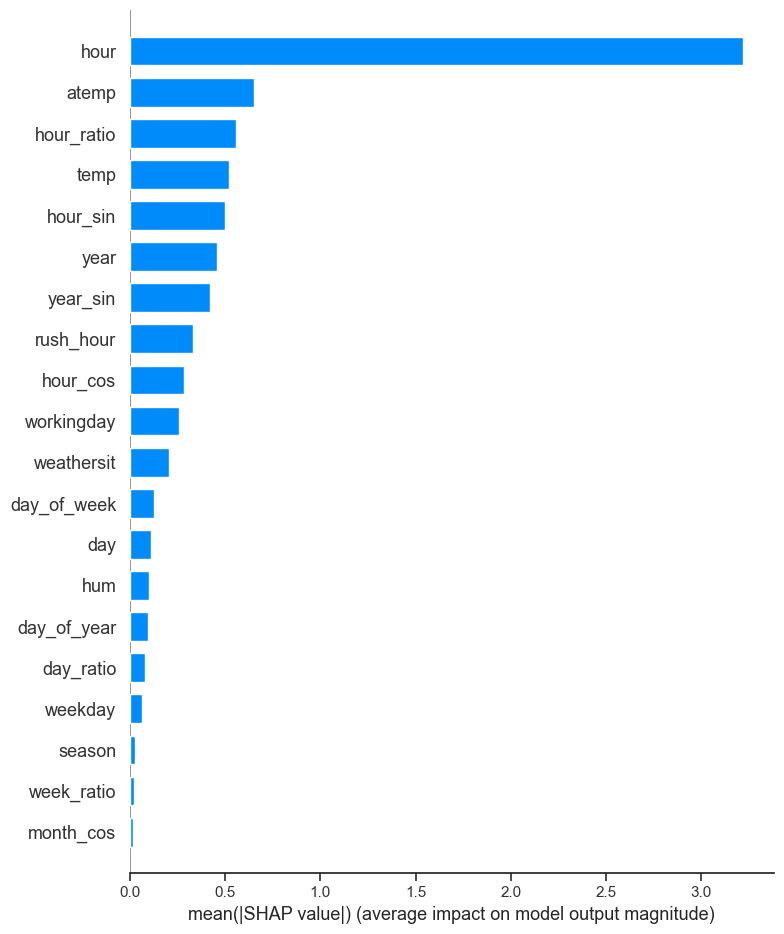

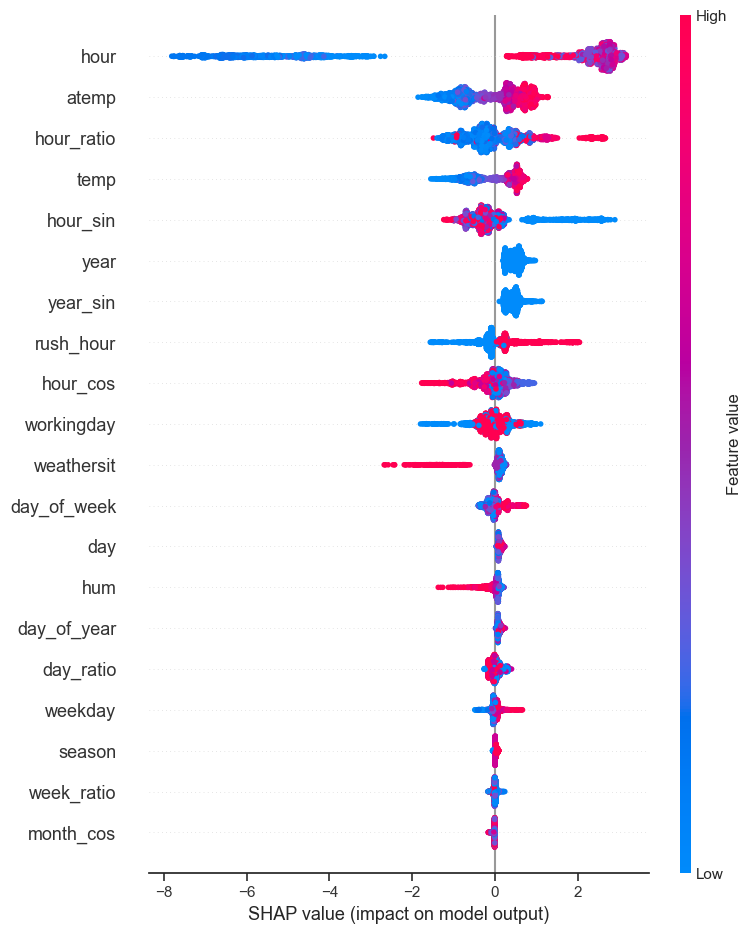

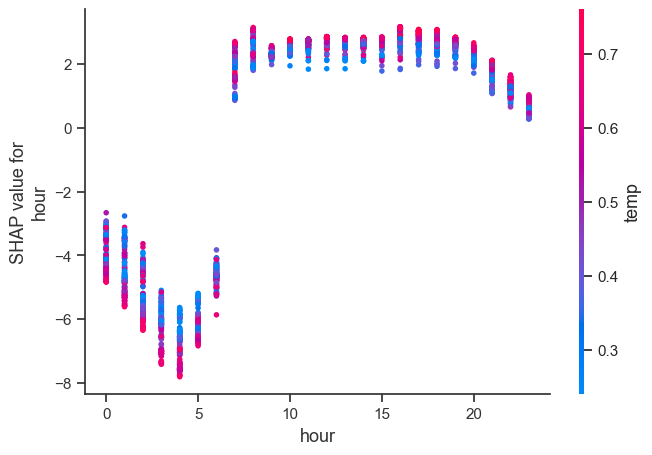

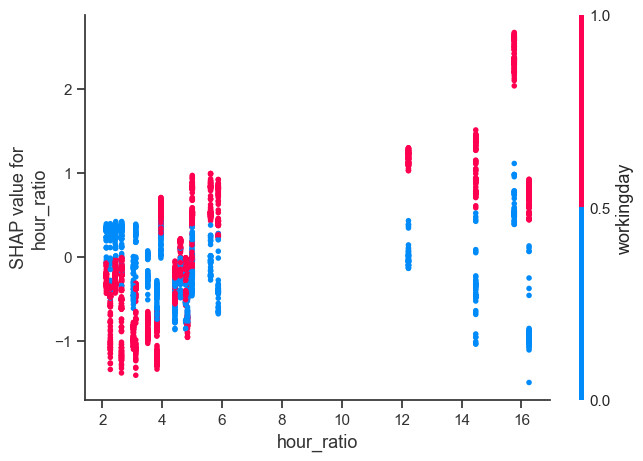

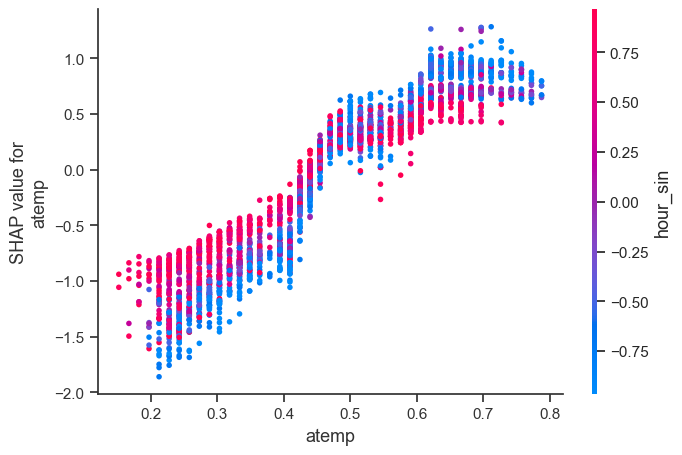

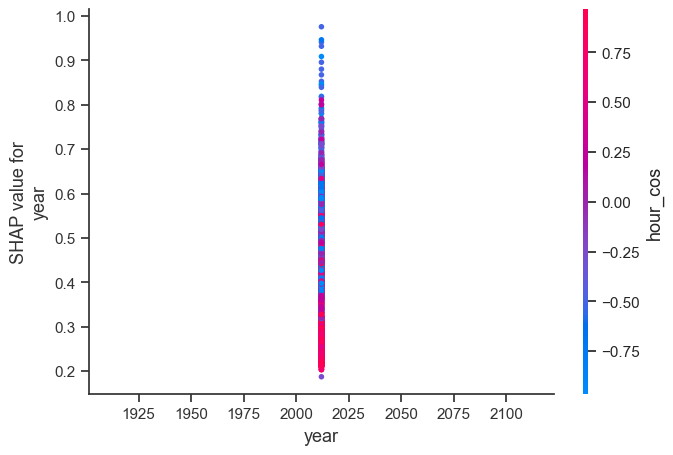

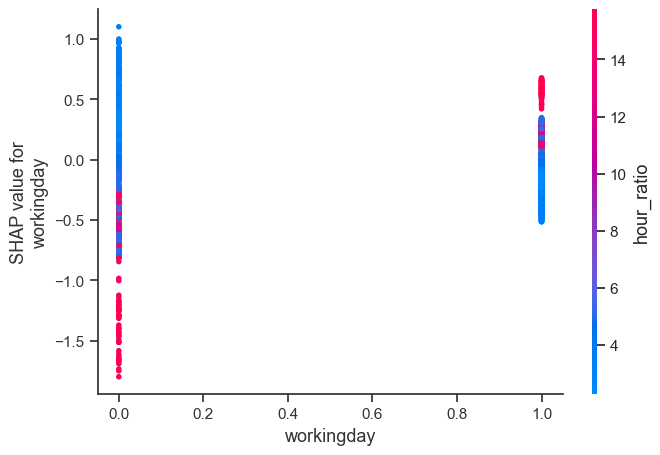

In [94]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

shap.summary_plot(shap_values, X_val)

shap.dependence_plot("hour", shap_values, X_val)
shap.dependence_plot("hour_ratio", shap_values, X_val)
shap.dependence_plot("atemp", shap_values, X_val)
shap.dependence_plot("year", shap_values, X_val)
shap.dependence_plot("workingday", shap_values, X_val)

shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0, :], X_val.iloc[0, :])

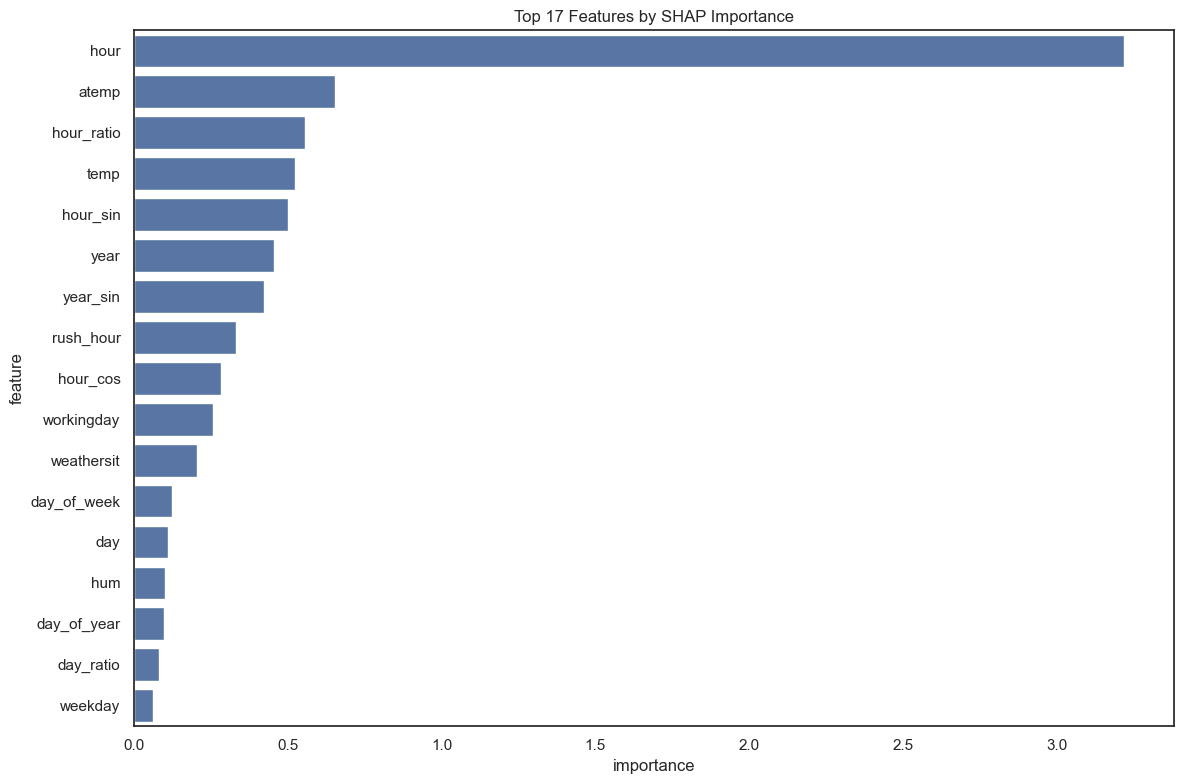

Top 17 Features by SHAP Importance:
1. hour: 3.219666
2. atemp: 0.653940
3. hour_ratio: 0.557895
4. temp: 0.522648
5. hour_sin: 0.499891
6. year: 0.457319
7. year_sin: 0.423852
8. rush_hour: 0.333716
9. hour_cos: 0.283715
10. workingday: 0.256715
11. weathersit: 0.206299
12. day_of_week: 0.125908
13. day: 0.112230
14. hum: 0.102747
15. day_of_year: 0.097323
16. day_ratio: 0.080691
17. weekday: 0.062680


In [95]:
# Calculate the mean absolute SHAP values for each feature
shap_importance = pd.DataFrame({
    'feature': X_val.columns,
    'importance': np.abs(shap_values).mean(axis=0)
})

# Sort by importance
shap_importance = shap_importance.sort_values('importance', ascending=False)

# Get top 17 features
top_30_features = shap_importance.head(30)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_17_features)
plt.title('Top 17 Features by SHAP Importance')
plt.tight_layout()
plt.show()

# Print the top 17 features
print("Top 17 Features by SHAP Importance:")
for i, (feature, importance) in enumerate(zip(top_17_features['feature'], top_17_features['importance'])):
    print(f"{i+1}. {feature}: {importance:.6f}")

In [100]:

# Get top 17 features
top_30_features = shap_importance.head(30)
top_30_features['feature'].to_list()

['hour',
 'atemp',
 'hour_ratio',
 'temp',
 'hour_sin',
 'year',
 'year_sin',
 'rush_hour',
 'hour_cos',
 'workingday',
 'weathersit',
 'day_of_week',
 'day',
 'hum',
 'day_of_year',
 'day_ratio',
 'weekday',
 'season',
 'week_ratio',
 'month_cos',
 'working_day',
 'windspeed',
 'week',
 'working_day_or_weekend_ratio',
 'weekend',
 'holiday',
 'day_sin',
 'moonphase',
 'day_cos',
 'month']